In [1]:
import operator
import random
import requests
import time
import csv
import os
import pandas as pd
import seaborn as sns
import numpy as np
import networkx as nx
from scipy import stats
from ast import literal_eval
from matplotlib import pyplot as plt
from statsmodels.stats import diagnostic
from datetime import datetime
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler

#colors used when comparing genders
PURPLE = 'purple'
ORANGE = '#ffb82c'

#colors used when generic comparisons
BLUE = '#0173b2'
RED = '#d55e00'

#print(sns.color_palette("colorblind").as_hex())
#sns.color_palette("colorblind")

In [2]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

## Table of Contents
* 1. Load the data
    * 1.1 Characters dataset
    * 1.2 Movies dataset
* 2. Quick look at the data
    * 2.1 Characters dataset
    * 2.2 Movies dataset
* 3. Data preprocessing
    * 3.1 Characters dataset
    * 3.2 Movies dataset
* 4. Data preparation
    * 4.1 Characters dataset
    * 4.2 Actors dataset
    * 4.3 Movies dataset
* 5. Data exploration
    * 5.1 Characters distribution
    * 5.2 Movies dataset
    * 5.3 Zoom on American movies
* 6. Data as a graph
    * 6.1 Node degree distribution
    * 6.2 Actors intersection between genres
    * 6.3 Genre evolution in career length
* 7. The numbers data: Domestic Per Year Acting Box Office Star Records
    * 7.1 Load the data
    * 7.2 Creation of a pipeline
    * 7.3 Comparing the numbers dataset with the CMU dataset

# 1. Load the data
<a class="anchor" id="load"></a>

In [3]:
DATA_PATH = './data'
MOVIE_PATH = os.path.join(DATA_PATH, 'movie.metadata.tsv')
CHAR_PATH = os.path.join(DATA_PATH, 'character.metadata.tsv')
PLOT_PATH = os.path.join(DATA_PATH, 'plot_summaries.txt')
ETHNICITIES_PATH =  os.path.join('ethnicities.csv')
THE_NUMBERS_PATH = os.path.join(DATA_PATH, 'actors_xxxx_the_numbers')

### 1.1 Characters data
<a class="anchor" id="load_characters"></a>

In [4]:
a_cols = ['wikipedia_m_ID', 'freebase_m_ID', 'm_release_date','character_name', 'actor_dob', 'actor_gender', 'actor_height', 'actor_ethnicity', 'actor_name', 'actor_age', 'freebase_character_map', 'freebase_character_id', 'freebase_actor_id']
df_chars=pd.read_csv(CHAR_PATH, sep='\t', names=a_cols)

### 1.2 Movies data
<a class="anchor" id="load_movies"></a>

In [5]:
m_cols = ["wikipedia_m_ID", "freebase_m_ID", "m_name", "m_release_date", "m_BO_revenue", "m_runtime", "m_languages", "m_countries", "m_genres"]
df_movies=pd.read_csv(MOVIE_PATH, sep='\t', names=m_cols, converters={'m_languages': literal_eval, 'm_countries': literal_eval, 'm_genres': literal_eval})

# 2. Quick look at the data
<a class="anchor" id="quicklook"></a>

### 2.1 Characters dataset
<a class="anchor" id="quicklook_characters"></a>

In [6]:
df_chars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 450669 entries, 0 to 450668
Data columns (total 13 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   wikipedia_m_ID          450669 non-null  int64  
 1   freebase_m_ID           450669 non-null  object 
 2   m_release_date          440674 non-null  object 
 3   character_name          192794 non-null  object 
 4   actor_dob               344524 non-null  object 
 5   actor_gender            405060 non-null  object 
 6   actor_height            154824 non-null  float64
 7   actor_ethnicity         106058 non-null  object 
 8   actor_name              449441 non-null  object 
 9   actor_age               292556 non-null  float64
 10  freebase_character_map  450669 non-null  object 
 11  freebase_character_id   192804 non-null  object 
 12  freebase_actor_id       449854 non-null  object 
dtypes: float64(2), int64(1), object(10)
memory usage: 44.7+ MB


In [7]:
df_chars.sample(4)

,wikipedia_m_ID,freebase_m_ID,m_release_date,character_name,actor_dob,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age,freebase_character_map,freebase_character_id,freebase_actor_id
370233,168929,/m/016mhd,2000-10-03,Mrs. Wilkinson,1950-02-22,F,1.60,/m/02w7gg,Julie Walters,50.0,/m/0jvcyq,/m/0by43zw,/m/016nff
254119,10117636,/m/02q2bzv,2007-03-08,NaN,NaN,NaN,NaN,NaN,Choo Seong Ng,NaN,/m/0gchgcv,NaN,/m/0gchgcy
358963,14290342,/m/03c_k9h,1917-10-28,NaN,1859-02-04,M,NaN,NaN,Gus Leonard,NaN,/m/0jvrrgb,NaN,/m/02z99f3
309917,2554528,/m/07mp6m,1986-01-31,NaN,1941-12-10,F,1.57,NaN,Fionnula Flanagan,44.0,/m/0cg5y5c,NaN,/m/07jhfz


### 2.2 Movies dataset
<a class="anchor" id="quicklook_movies"></a>

In [8]:
df_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81741 entries, 0 to 81740
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   wikipedia_m_ID  81741 non-null  int64  
 1   freebase_m_ID   81741 non-null  object 
 2   m_name          81741 non-null  object 
 3   m_release_date  74839 non-null  object 
 4   m_BO_revenue    8401 non-null   float64
 5   m_runtime       61291 non-null  float64
 6   m_languages     81741 non-null  object 
 7   m_countries     81741 non-null  object 
 8   m_genres        81741 non-null  object 
dtypes: float64(2), int64(1), object(6)
memory usage: 5.6+ MB


In [9]:
df_movies.sample(4)

,wikipedia_m_ID,freebase_m_ID,m_name,m_release_date,m_BO_revenue,m_runtime,m_languages,m_countries,m_genres
21580,34419411,/m/0h_cr_t,Villa Zone,1975-05-30,NaN,79.0,{'/m/01bkv': 'Bulgarian Language'},{'/m/015qh': 'Bulgaria'},"{'/m/01t_vv': 'Comedy-drama', '/m/05p553': 'Co..."
69918,12947954,/m/02z10vj,Bachke Rehna Re Baba,2005,NaN,130.0,{'/m/03k50': 'Hindi Language'},{'/m/03rk0': 'India'},"{'/m/06cvj': 'Romantic comedy', '/m/03q4nz': '..."
67226,1653423,/m/05kxf3,Sliding Doors,1998-04-24,NaN,99.0,{'/m/02h40lc': 'English Language'},"{'/m/09c7w0': 'United States of America', '/m/...","{'/m/01t_vv': 'Comedy-drama', '/m/01hmnh': 'Fa..."
24190,753557,/m/038gjc,Triumph of the Nerds,1996,NaN,NaN,{},{'/m/09c7w0': 'United States of America'},{'/m/0jtdp': 'Documentary'}


As shown with .info() methods, it can be seen that data is in the 100MB order so it can be handled in by our machines without any problem.

# 3. Data preprocessing
<a class="anchor" id="preprocessing"></a>

### 3.1 Characters dataset
<a class="anchor" id="preprocessing_characters"></a>

#### Columns conversion

In [10]:
#Change problematic dates
df_chars['m_release_date']=pd.to_datetime(df_chars['m_release_date'], errors = 'coerce')##min value of date '1010-12-02' qui plus petit que la plus petite date de to_datetime
df_chars['actor_dob'] = df_chars['actor_dob'].apply(lambda x: str(x) if len(str(x)) <=10 else str(x)[:10])
df_chars['actor_dob'] = pd.to_datetime(df_chars['actor_dob'], errors = 'coerce')

#### Actor age

In [11]:
# Number of characters whose actor has a negative age when appearing in the movie
nb_chars_negative_age = df_chars[df_chars['actor_age'] <= 0]['actor_age'].value_counts().sum()
print("There are {} characters whose actor has a negative age.".format(nb_chars_negative_age))

There are 433 characters whose actor has a negative age.


#### Actor name

In [12]:
# Number of characters whose actor is named 'NaN'
df_chars['actor_name'].value_counts(dropna=False)[:10]

NaN                   1228
Mel Blanc              791
Mithun Chakraborty     328
Oliver Hardy           299
Mohanlal               234
Moe Howard             225
Mammootty              225
Dharmendra Deol        219
Larry Fine             219
Amitabh Bachchan       206
Name: actor_name, dtype: int64

In [13]:
# Number of characters whose actor is named 'NaN'
nb_chars_nan = df_chars['actor_name'].value_counts(dropna=False)[np.nan]
print("There are {} characters whose actor name is nan.".format(nb_chars_nan))

There are 1228 characters whose actor name is nan.


#### Duplicated characters

In [14]:
# Number of duplicates
nb_char_duplicates = df_chars.duplicated().sum()
print("There are {} duplicated characters. So there is no duplicated row.".format(nb_char_duplicates))

There are 0 duplicated characters. So there is no duplicated row.


In [15]:
# Number of occurrences with same subset of columns as described below
nb_char_duplicates_sub = df_chars.duplicated(subset=['wikipedia_m_ID', 'character_name', 'actor_name', 'm_release_date']).sum()
print("There are {} characters which appear in the same movie with the same release date, have the same name and which are played by the same actor.".format(nb_char_duplicates_sub))

There are 1086 characters which appear in the same movie with the same release date, have the same name and which are played by the same actor.


#### Casting date of birth

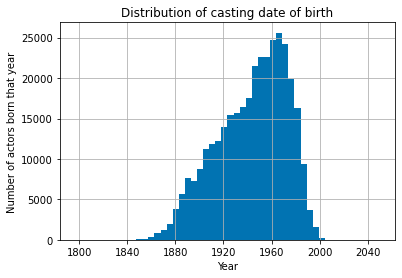

There are 59 actors born before 1850.
There are 1 actors born after 2013.


In [16]:
#Looking at date of birth
plt.title('Distribution of casting date of birth')
plt.xlabel('Year')
plt.ylabel('Number of actors born that year')
plt.hist(df_chars['actor_dob'], bins=50, color=BLUE)
plt.grid()
plt.show()
date_born_min = df_chars.loc[df_chars['actor_dob'].dt.year<1850]['wikipedia_m_ID'].count()
date_born_max = df_chars.loc[df_chars['actor_dob'].dt.year>2013]['wikipedia_m_ID'].count()
print("There are {} actors born before 1850.\nThere are {} actors born after 2013.".format(date_born_min, date_born_max))

In [17]:
#The actors born before 1850 have all nan as age.
df_chars.loc[df_chars['actor_dob'].dt.year<1850]['actor_age'].unique()

array([nan])

In [18]:
#The actor born after 2013 has a negative age. He'll be dropped in the next cell
df_chars.loc[df_chars['actor_dob'].dt.year>2013]['actor_age'].unique()

array([-37.])

In [19]:
date_movie_first_release = df_chars['m_release_date'].min()
print("The first movie is released in {}.".format(date_movie_first_release.year))

The first movie is released in 1888.


The actor database contains following errors:
- **Actors with negative age**: is (at least in some cases (wikipedia_movie_id: 15007384)) due to actors having the same last name, which probably led to some scraping missmatch, e.g. a movie attributed to a son when it was in fact his father acting. We are going to drop those since it is clearly mistaken.
- **Actors with name 'Nan'**: there is no way for us to qualitatively use this data, so we will drop them.
- **Actors duplicates**: some duplicates were identified, we will safely remove them.
- **Actors with old date of birth**: there are some actors with really old date of birth (59 before 1850). It was decided to safely remove their characters.

#### Cleaning

In [20]:
def cast_age(x):
    try:
        value = int(x)
    except:
        value = np.nan
    return value

In [21]:
df_chars['actor_age'] = df_chars['actor_age'].apply(lambda x: cast_age(x))
df_chars['actor_age'] = df_chars.apply(lambda row: row['m_release_date'].year - row['actor_dob'].year if (row['actor_age']==np.nan and row['actor_dob']!=np.nan and row['m_release_date']!=np.nan) else row['actor_age'], axis=1)
df_chars = df_chars.loc[(df_chars['actor_age'] >=0) | (df_chars['actor_age'].isna())]

df_chars = df_chars.loc[(df_chars['actor_dob'].dt.year >=1850) | (df_chars['actor_dob'].isna())]
df_chars.dropna(subset='actor_name', inplace=True)
df_chars.drop_duplicates(subset=["wikipedia_m_ID", "character_name", "actor_name", "m_release_date"], keep=False, inplace=True)

### 3.2 Movies dataset
<a class="anchor" id="preprocessing_movies"></a>

#### Columns conversion

In [22]:
#Movie release dates are parsed as datetime.
df_movies['m_release_date']=pd.to_datetime(df_movies['m_release_date'], errors = 'coerce')

#### Movie freebase ID

In [23]:
#A sample of movies is taken to get their freebase ID. The average is then done on how much of them had a valid movie freebase ID.
tot = []
k_size = 8
n = 100
for k in range(k_size):
    rd_elements = random.sample(df_movies['freebase_m_ID'].apply(lambda x: x.split('/')[2]).to_list(), n)
    url='%28%3'
    for x in rd_elements:
        url += 'Ftitle%20%3D%20%22%2Fm%2F' + x + '%22%20%7C%7C%20%3'
    query = 'https://query.wikidata.org/bigdata/namespace/wdq/sparql?format=json&query=PREFIX%20wd%3A%20%3Chttp%3A%2F%2Fwww.wikidata.org%2Fentity%2F%3E%0APREFIX%20wdt%3A%20%3Chttp%3A%2F%2Fwww.wikidata.org%2Fprop%2Fdirect%2F%3E%0APREFIX%20wikibase%3A%20%3Chttp%3A%2F%2Fwikiba.se%2Fontology%23%3E%0A%0ASELECT%20%20%3Fs%20%3Ftitle%20WHERE%20%7B%20%0A%20%20VALUES%20%3Fmovietype%20%7B%20wd%3AQ11424%7D%0A%20%20%3Fs%20p%3AP31%2Fps%3AP31%20%3Fmovietype.%0A%20%20%3Fs%20wdt%3AP646%20%3Ftitle.%0A%20%20FILTER{}%22%29%0A%0A%20%20%20SERVICE%20wikibase%3Alabel%20%7B%0A%20%20%20%20bd%3AserviceParam%20wikibase%3Alanguage%20%22en%22%20.%0A%20%20%20%7D%0A%20%7D'.format(url[:-17])
    response = requests.get(query)
    response = response.json()['results']['bindings']
    tot.append(len(response))

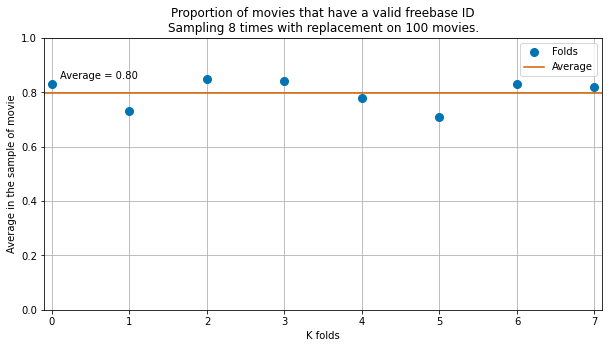

There is around 79.88% of the movies that have an active wikipedia freebase ID.


In [24]:
ratio = [x/n for x in tot]
avg_ratio = sum(ratio)/k_size
plt.figure(figsize=(10, 5))
plt.plot(np.linspace(0, k_size-1, k_size).astype(int), ratio, marker='o', linewidth=0, markersize=8, color=BLUE, label='Folds')
plt.xticks(np.linspace(0, k_size-1, k_size).astype(int))
plt.plot(np.linspace(-1, k_size, k_size).astype(int), [avg_ratio]*k_size, color=RED, label='Average')
plt.xlim(- 0.1, k_size -1 + 0.1)
plt.ylim(0, 1)
plt.xlabel("K folds")
plt.ylabel("Average in the sample of movie")
plt.grid()
plt.text(0.1, avg_ratio + 0.05, "Average = {:.2f}".format(avg_ratio))
plt.legend()
plt.title("Proportion of movies that have a valid freebase ID\nSampling {} times with replacement on {} movies.".format(k_size, n))
plt.show()
print("There is around {:.2f}% of the movies that have an active wikipedia freebase ID.".format(avg_ratio*100))

#### Critical values

In [25]:
#Number of movies with critical values.
nb_critical_values = df_movies[~df_movies.astype(bool).all(axis=1)].shape[0]
print("There are {} rows with critical values. These are values such as: empty dictionaries, 0, nan, etc.".format(nb_critical_values))

There are 17949 rows with critical values. These are values such as: empty dictionaries, 0, nan, etc.


#### Duplicated rows

In [26]:
df_temp = df_movies.copy()
df_temp['m_languages'] = df_temp['m_languages'].apply(lambda x: str(list(x.values())))
df_temp['m_countries'] = df_temp['m_countries'].apply(lambda x: str(list(x.values())))
df_temp['m_genres'] = df_temp['m_genres'].apply(lambda x: str(list(x.values())))
nb_movie_duplicated_rows = df_temp.duplicated().sum()
print("There are {} duplicated rows in the movie dataset.".format(nb_movie_duplicated_rows))

There are 0 duplicated rows in the movie dataset.


#### Duplicated movies

In [27]:
df_movies[df_movies.duplicated(subset=['m_name', 'm_release_date'], keep=False)].sort_values('m_name').head(4)

,wikipedia_m_ID,freebase_m_ID,m_name,m_release_date,m_BO_revenue,m_runtime,m_languages,m_countries,m_genres
64872,24604084,/m/080cdj1,A,1998-01-01,NaN,136.0,{'/m/03_9r': 'Japanese Language'},{'/m/03_3d': 'Japan'},"{'/m/0gw5n2f': 'Japanese Movies', '/m/03q4nz':..."
66267,23488527,/m/06w8mcl,A,1998-01-01,NaN,NaN,{'/m/09bnf': 'Kannada Language'},{'/m/03rk0': 'India'},{'/m/02l7c8': 'Romance Film'}
38544,33545449,/m/0hgrdzf,A Sister to Assist 'Er,NaT,NaN,59.0,{},{},{'/m/05p553': 'Comedy film'}
74307,33545395,/m/0hgrll0,A Sister to Assist 'Er,NaT,NaN,64.0,{},{},{'/m/05p553': 'Comedy film'}


In [28]:
#Number of duplicated movies.
nb_movies_duplicated = df_movies[df_movies.duplicated(subset=['m_name', 'm_release_date'], keep=False)]['wikipedia_m_ID'].count()
print("There are {} duplicated movies.".format(nb_movies_duplicated))

There are 196 duplicated movies.


#### Movie release date

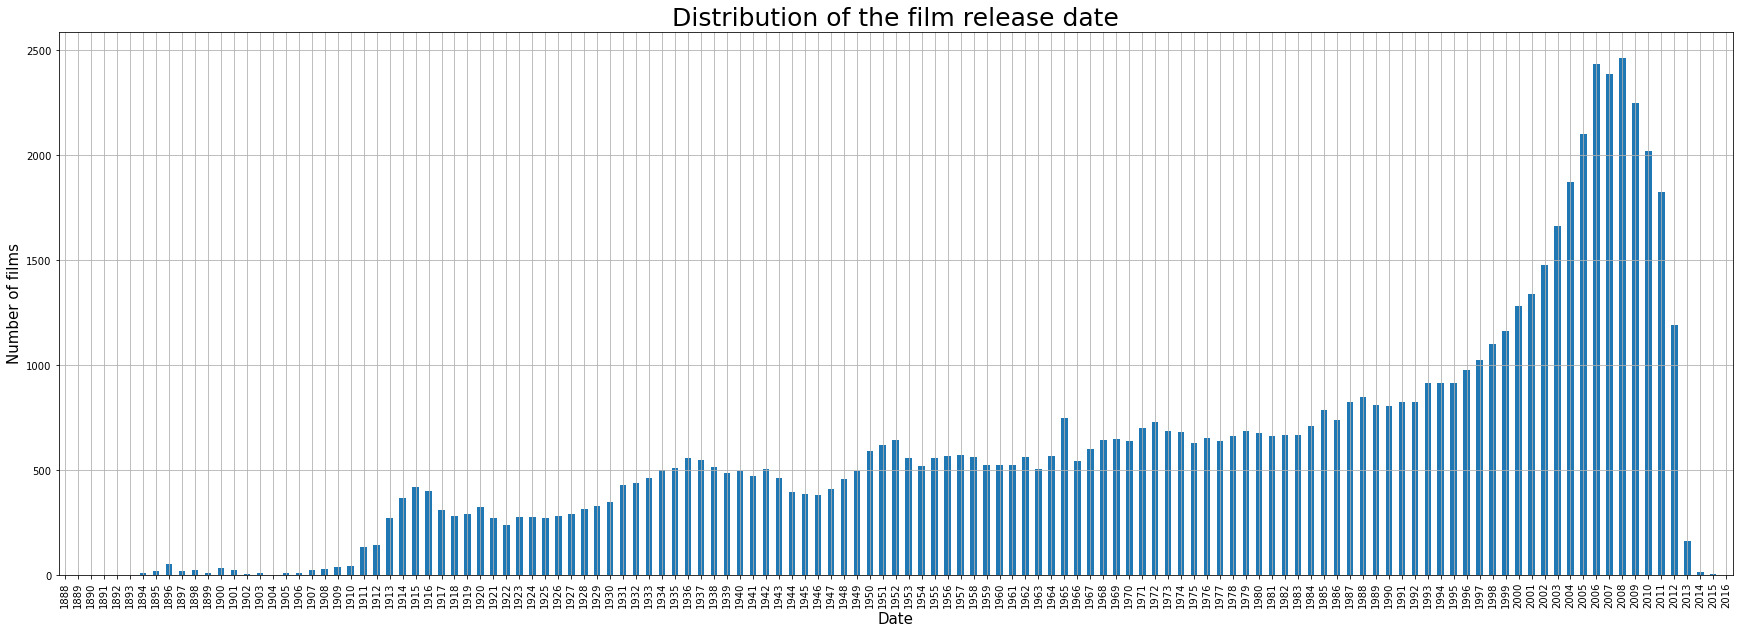

In [29]:
#Movie release date quick overview
df_movies['m_release_date'].dropna().dt.year.sort_values().value_counts(sort=False).plot(kind='bar', figsize=(30,10))
plt.grid()
plt.title('Distribution of the film release date', fontsize=25)
plt.xlabel('Date', fontsize=15)
plt.ylabel('Number of films', fontsize=15)
plt.show()

In [30]:
#Quick look at the movies after 2013.
df_movies[df_movies['m_release_date'].dt.year > 2013].sort_values('m_release_date', ascending=False).head()

,wikipedia_m_ID,freebase_m_ID,m_name,m_release_date,m_BO_revenue,m_runtime,m_languages,m_countries,m_genres
34022,23124260,/m/064mmw7,Jeepers Creepers 4,2016-06-08,NaN,NaN,{},{'/m/09c7w0': 'United States of America'},"{'/m/01jfsb': 'Thriller', '/m/03npn': 'Horror'}"
30275,27554912,/m/0c03gcc,Kung Fu Panda 3,2016-03-18,NaN,NaN,{},{},{}
64862,3139382,/m/08tyfg,Battle Angel,2016-01-01,NaN,NaN,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},"{'/m/01jfsb': 'Thriller', '/m/06n90': 'Science..."
51429,25813358,/m/0gmbk1g,Avatar 2,2015-01-01,NaN,NaN,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},"{'/m/06n90': 'Science Fiction', '/m/02kdv5l': ..."
53855,32416903,/m/0gys9tc,Total Dhamaal,2015-01-01,NaN,138.0,{'/m/03k50': 'Hindi Language'},{},{'/m/05p553': 'Comedy film'}


In [31]:
nb_movies_after_2013 = df_movies[df_movies['m_release_date'].dt.year > 2013].shape[0]
print("There are {} movies released after 2013. It can be seen that several movies have a wrong date of release (e.g Avatar 2).".format(nb_movies_after_2013))

There are 24 movies released after 2013. It can be seen that several movies have a wrong date of release (e.g Avatar 2).


#### Movie runtime

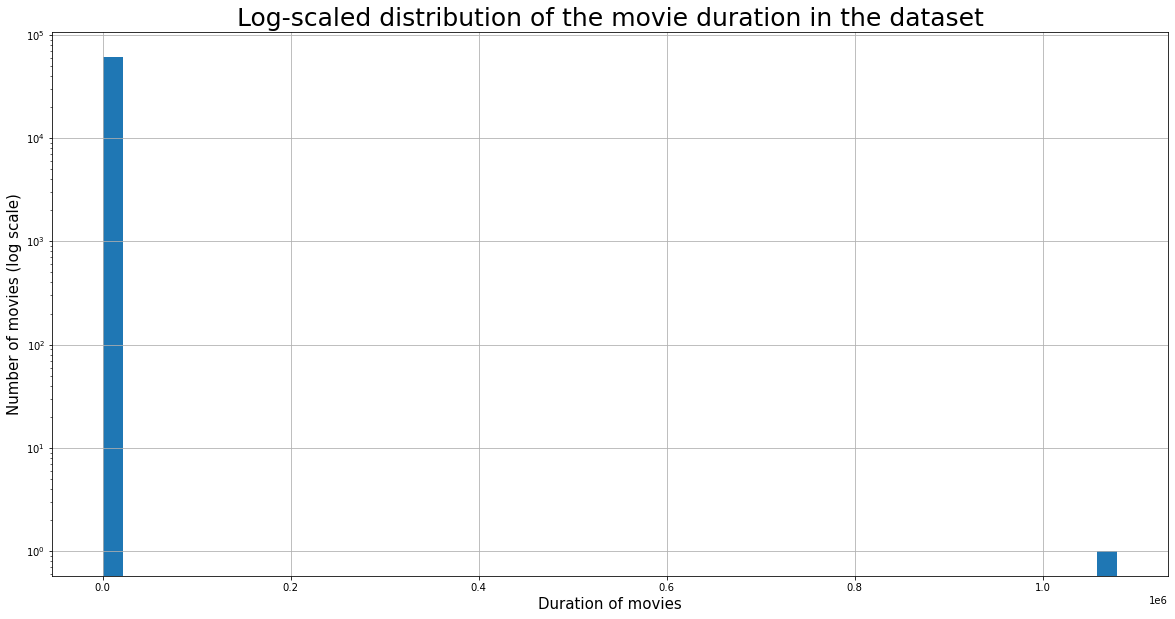

In [32]:
plt.figure(figsize=(20,10))
df_movies.m_runtime.hist(bins=50)
plt.yscale('log')
plt.ylabel('Number of movies (log scale)', fontsize=15)
plt.xlabel('Duration of movies', fontsize=15)
plt.title("Log-scaled distribution of the movie duration in the dataset", fontsize=25)
plt.show()

In [33]:
nb_movies_duration_inf_1 = df_movies[(df_movies['m_runtime']>= 1500)]['wikipedia_m_ID'].count()
nb_movies_duration_supp_1500 = df_movies[(df_movies['m_runtime']<= 1)]['wikipedia_m_ID'].count()
print("There are {} movies which a runtime > 1500 and {} movies with a runtime < 1.".format(nb_movies_duration_inf_1, nb_movies_duration_supp_1500))

There are 14 movies which a runtime > 1500 and 107 movies with a runtime < 1.


One can see that there are some outliers in the runtime. It might be due to the time conversion. As the runtime input is supposed to be in minutes, freebase ID will be queried using wikidata to know whether the runtime is the correct one.

The movie database contains following errors:
- **Critical values**: There are values such as empty dictionaries, 0, False in the rows. For practicity, they'll be all replaced by np.nan values.
- **Duplicated movies**: There are movies that can be considered identical (same movie name and same release date). Some of them are duplicated. They'll be safely removed by keeping the first one as they represent the same movie.
- **Movie release date**: There are some outliers in the movie release date. This mainly concerns movies after 2013. It is due to the creation date of the dataset: 2013. It means all the movies after 2013 are probable dates of release rather than effective ones. Those will be queried using freebase movie ID and changed when possible (as it might be earlier). After this operation, the movies after 2013 will be dropped as it was too recent regarding the dataset creation. This is also a reason why there is too few movies after 2013.
- **Movie runtime**: There are some outliers in the movie runtime. Movie runtime is supposed to be in minutes. However, there is one movie that would last 60 days. In the other way, there are many films that last less than a minute. It is probable that all those cases are due to wrong conversions (i.e duration expressed in seconds or in hours). Those will be queried using freebase movie ID and changed when possible. If the movie does not exist using freebase, the runtime will be kept. But when studying runtime, it will be important to remember those edgecases.

#### Cleaning

In [34]:
df_movies=df_movies.where(df_movies.astype(bool),np.nan).drop_duplicates(subset=['m_name', 'm_release_date'], keep='first')

In [35]:
feature_wiki_ID={
    "runtime": 'AP2047',
    "pubdate":'AP577'
}

def get_freebase_feature_movie(row, value, op, n_lim, feature):
    ops = {
    '>=' : operator.ge,
    '<=' : operator.le,
    '>' : operator.gt,
    '<' : operator.lt,
    }
    op = ops[op]
        
    if feature == 'pubdate':
        val_to_compare=value.year
    else:
        val_to_compare = value
    
    if op(val_to_compare, n_lim):
        id_m = str(row['freebase_m_ID'].split('/')[2])
        query = 'https://query.wikidata.org/bigdata/namespace/wdq/sparql?format=json&query=PREFIX%20wd%3A%20%3Chttp%3A%2F%2Fwww.wikidata.org%2Fentity%2F%3E%0APREFIX%20wdt%3A%20%3Chttp%3A%2F%2Fwww.wikidata.org%2Fprop%2Fdirect%2F%3E%0APREFIX%20wikibase%3A%20%3Chttp%3A%2F%2Fwikiba.se%2Fontology%23%3E%0A%0ASELECT%20%20%3Fs%20%3FsLabel%20%3Fp%20%20%3Fo%20%3FoLabel%20%3F{}%20WHERE%20%7B%0A%20%3Fs%20wdt%3AP646%20%22%2Fm%2F{}%22.%0A%20%3Fs%20wdt%3{}%20%3F{}.%0A%0A%20%20%20SERVICE%20wikibase%3Alabel%20%7B%0A%20%20%20%20bd%3AserviceParam%20wikibase%3Alanguage%20%22en%22%20.%0A%20%20%20%7D%0A%20%7D'.format(feature, id_m, feature_wiki_ID[feature], feature)
        response_json = requests.get(query).json()['results']['bindings']
        if len(response_json):
            
            if feature == 'runtime':
                new_value = float(response_json[0][feature]['value'])
                if new_value!=value:
                    time.sleep(2)
                    print("{} movie had a {} of {:.2f}. However, using freebase ID, {}={}min.".format(row['m_name'], feature,
                                                                                               value, feature, 
                                                                                               new_value))
                    value = new_value
            elif feature=='pubdate':
                new_value = (response_json[0][feature]['value'])
                new_value=new_value.replace("Z", "")
                new_value = datetime.strptime(new_value,'%Y-%m-%dT%H:%M:%S')
                if new_value.year!=value.year:
                    print("{} movie had a {} of {}. However, using freebase ID, {}={}.".format(row['m_name'], feature,
                                                                                               value.date(), feature, 
                                                                                               new_value.date()))
                    value = new_value
            
    return value

In [36]:
time.sleep(10)
df_movies['m_release_date'] = df_movies[['m_release_date', 'freebase_m_ID', 'm_name']].apply(lambda row: get_freebase_feature_movie(row, row['m_release_date'], '>=', 2015, 'pubdate'), axis=1)

Avatar 2 movie had a pubdate of 2015-01-01. However, using freebase ID, pubdate=2022-12-14.
Total Dhamaal movie had a pubdate of 2015-01-01. However, using freebase ID, pubdate=2018-12-07.
Battle Angel movie had a pubdate of 2016-01-01. However, using freebase ID, pubdate=2019-02-06.


In [37]:
df_movies = df_movies[df_movies.m_release_date.dt.year < 2013]

In [38]:
time.sleep(10)
df_movies['m_runtime'] = df_movies[['m_runtime', 'freebase_m_ID', 'm_name']].apply(lambda row: get_freebase_feature_movie(row, row['m_runtime'], '>', 1500, 'runtime'), axis=1)
df_movies['m_runtime'] = df_movies[['m_runtime', 'freebase_m_ID', 'm_name']].apply(lambda row: get_freebase_feature_movie(row, row['m_runtime'], '<', 1, 'runtime'), axis=1)

Zero Tolerance movie had a runtime of 1079281.00. However, using freebase ID, runtime=88.0min.
Dhool Ka Phool movie had a runtime of 1533.00. However, using freebase ID, runtime=153.0min.
Cinématon movie had a runtime of 9360.00. However, using freebase ID, runtime=11828.0min.
Dil Ne Phir Yaad Kiya movie had a runtime of 1966.00. However, using freebase ID, runtime=148.0min.
As Seen Through a Telescope movie had a runtime of 0.70. However, using freebase ID, runtime=55.0min.
Men Boxing movie had a runtime of 0.08. However, using freebase ID, runtime=5.0min.
Fred Ott's Sneeze movie had a runtime of 0.08. However, using freebase ID, runtime=4.0min.
Sick Kitten movie had a runtime of 0.57. However, using freebase ID, runtime=34.0min.
The X-Rays movie had a runtime of 0.73. However, using freebase ID, runtime=44.0min.
Blacksmith Scene movie had a runtime of 0.57. However, using freebase ID, runtime=34.0min.
L'Arroseur Arrosé movie had a runtime of 0.82. However, using freebase ID, runtime=

# 4 Dataset preparation
<a class="anchor" id="datapreparation"></a>

### 4.1 Characters dataset
<a class="anchor" id="datapreparation_characters"></a>

The ethnicity of each actor is mapped using a wikidata freebase query.

In [39]:
dict_ethnicities = {}
def map_ethnicities(arr_ethn):
    """
    Queries the FreeBase dump to get ethnicities as dict instead of Freebase ID.
    :param arr_ethn: array of ethnicities
    :return:
    """
    for x in arr_ethn[1:]:
        time.sleep(1)
        x = x.split('/')[2]
        query = 'https://query.wikidata.org/bigdata/namespace/wdq/sparql?format=json&query=PREFIX%20wd%3A%20%3Chttp%3A%2F%2Fwww.wikidata.org%2Fentity%2F%3E%0APREFIX%20wdt%3A%20%3Chttp%3A%2F%2Fwww.wikidata.org%2Fprop%2Fdirect%2F%3E%0APREFIX%20wikibase%3A%20%3Chttp%3A%2F%2Fwikiba.se%2Fontology%23%3E%0A%0ASELECT%20%20%3Fs%20%3FsLabel%20WHERE%20%7B%0A%20%3Fs%20wdt%3AP646%20%22%2Fm%2F{}%22.%0A%0A%20%20%20SERVICE%20wikibase%3Alabel%20%7B%0A%20%20%20%20bd%3AserviceParam%20wikibase%3Alanguage%20%22en%22%20.%0A%20%20%20%7D%0A%20%7D'.format(x)
        response_json = requests.get(query).json()['results']['bindings']
        if len(response_json):
            value = response_json[0]['sLabel']['value']
            dict_ethnicities.update({'/m/'+x: value})

def save_ethnicities(dict_):
    """
    Saves ethnicities list in a file from the dict created in map_ethnicities.

    :return:
    """
    csv_columns = ['freebase_ID', 'value']
    with open(ETHNICITIES_PATH, 'w', encoding="utf-8") as f:
        writer_object = csv.writer(f)
        for key in dict_.keys():
            value = dict_[key]
            writer_object.writerow([key, value])
        f.close()
    return

def get_ethnicities():
    """
    Creates a dict for ethnicities, as strings to be able to read them.

    :return: dict, ideal to give to a DataFrame
    """
    ethnicities = {}
    with open(ETHNICITIES_PATH, 'r', encoding="utf-8") as f:
        reader_object = csv.reader(f)
        for data in reader_object:
            if data:
                key, value = data
                ethnicities.update({key:value})
    return ethnicities

In [40]:
#Those lines were run only once in order to create the 'ethnicities.csv' file. They query the wikidata database to get the name of the ethnicities.

map_ethnicities(df_chars['actor_ethnicity'].dropna().unique())
save_ethnicities(dict_ethnicities)

In [41]:
ethnicities = get_ethnicities()

In [42]:
df_chars['actor_ethnicity'] = df_chars['actor_ethnicity'].apply(lambda x: ethnicities[x] if x in ethnicities.keys() else np.nan)

### 4.2 Actor dataset
<a class="anchor" id="datapreparation_actors"></a>

Unique actors will be computed using the unique features (actor_name, actor_dob), as it is what will be used to map the actors to a popularity database. They will be saved in df_actors.

In [43]:
df_actors = df_chars.drop_duplicates(subset=['actor_dob', 'actor_name'], keep='first')

### 4.3 Movie dataset
<a class="anchor" id="datapreparation_movies"></a>

3 columns of the movie dataset will be split: movie languages, movie country of production and movie genres. They will be split in two columns: freebase ID in the first, and value in the other.

In [44]:
def split_feature(row, feature, flag):
    """
    Splits list-like columns into key for freebase_ID and value for the value.

    :param row: Row to apply the split
    :param feature: Column to split
    :param flag: Takes the value if True, the key if False
    :return: The value or the key of row[feature]
    """
    if isinstance(row[feature], float):
        return np.nan
    elif flag:
        return list(row[feature].values())
    else:
        return row[feature].keys()

In [45]:
features = ['m_languages', 'm_countries', 'm_genres']
_freebase_ID = '_freebase_ID'
for i, feature in enumerate(features):
    df_movies[feature+_freebase_ID] = df_movies.apply(lambda row: split_feature(row, feature, 0), axis=1)
    df_movies[feature] = df_movies.apply(lambda row: split_feature(row, feature, 1), axis=1)

# 5. Data exploration
<a class="anchor" id="dataexploration"></a>

In [46]:
nb_actors = df_actors['actor_name'].count()
nb_actors_freebase_id = df_chars['freebase_actor_id'].drop_duplicates().count()
print("There are {} actors with different (name, date of birth) in the dataset. However, there are {} different actor freebase ID.".format(nb_actors, nb_actors_freebase_id))

There are 134734 actors with different (name, date of birth) in the dataset. However, there are 135158 different actor freebase ID.


The difference between the two figures is due to some incorrect matching (actor --> actor freebase ID). Those won't be taken into account when analysing "unique actors".

### 5.1 Characters and actors analysis
<a class="anchor" id="datapreparation_characters"></a>

#### Characters distribution

In [47]:
nb_chars = df_chars['wikipedia_m_ID'].count()
nb_chars_with_freebase = df_chars['freebase_character_id'].count()
print("There are {} characters and only {:.2f}% of them has a known freebase character ID.".format(nb_chars, nb_chars_with_freebase/nb_chars*100))

There are 447653 characters and only 42.77% of them has a known freebase character ID.


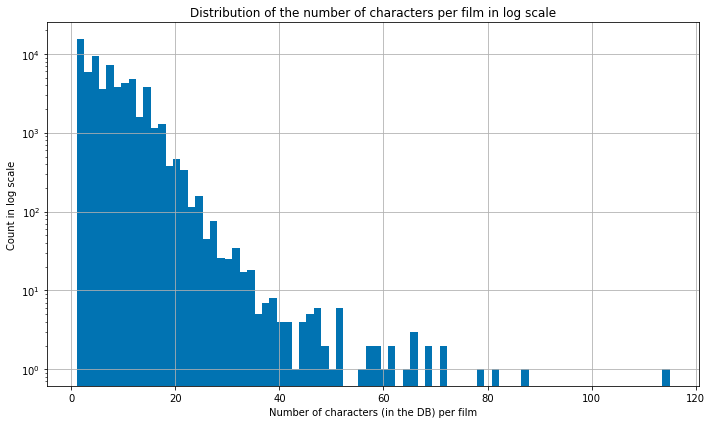

In [48]:
# Plots distribution of characters per movie
plt.figure(figsize=(10,6))
plt.title('Distribution of the number of characters per film in log scale')
plt.xlabel('Number of characters (in the DB) per film')
plt.ylabel('Count in log scale')
plt.hist(df_chars['wikipedia_m_ID'].value_counts(), log=True, bins=80, color=BLUE)
plt.tight_layout()
plt.grid()
plt.show()

#### Casting age

In [49]:
nb_chars_with_age = df_chars['actor_age'].value_counts().sum()
print("There are {} characters whose actor has a known age at the time he·she played the movie, which represents {:.2f}% of the characters.".format(nb_chars_with_age, nb_chars_with_age/nb_chars*100))

There are 291180 characters whose actor has a known age at the time he·she played the movie, which represents 65.05% of the characters.


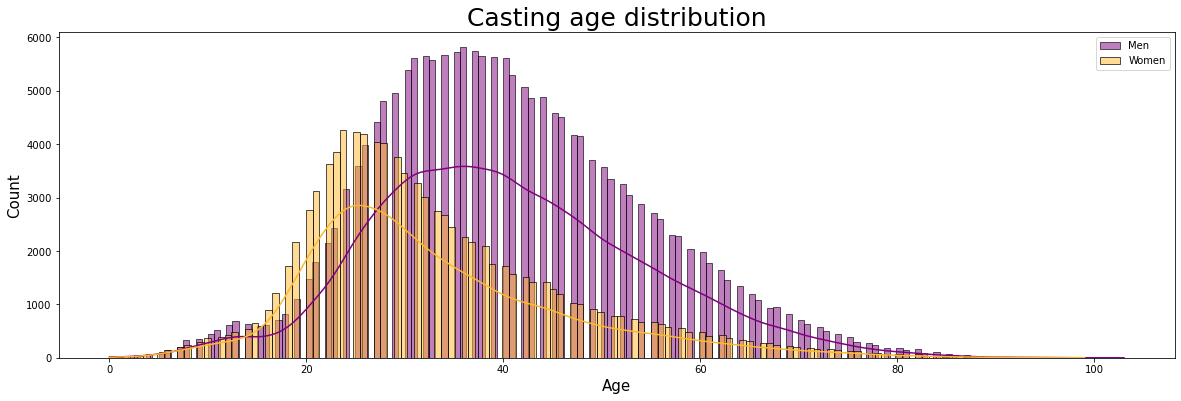

In [50]:
plt.figure(figsize=(20,6))
sns.histplot(df_chars[df_chars.actor_gender == 'M'].actor_age, color=PURPLE, kde=True, label="Men")
sns.histplot(df_chars[df_chars.actor_gender == 'F'].actor_age, color=ORANGE, kde=True, label="Women")
plt.title("Casting age distribution", fontsize=25)
plt.xlabel("Age", fontsize=15)
plt.ylabel("Count", fontsize=15)
plt.legend()
plt.show()

#### Casting gender

In [51]:
nb_chars_with_gender = df_chars['actor_gender'].value_counts().sum()
print("There are {} characters whose actor has a known gender at the time he·she played the movie, which represents {:.2f}% of the characters.".format(nb_chars_with_gender, nb_chars_with_gender/nb_chars*100))

There are 403364 characters whose actor has a known gender at the time he·she played the movie, which represents 90.11% of the characters.


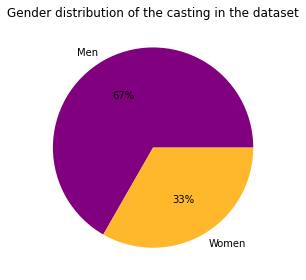

In [52]:
plt.title('Casting gender distribution')
plt.title('Gender distribution of the casting in the dataset')
plt.pie(df_chars['actor_gender'].value_counts(), labels=['Men', 'Women'], autopct='%.0f%%', colors=[PURPLE, ORANGE])
plt.tight_layout()
plt.show()

#### Actors gender

In [53]:
nb_actors_with_gender = df_actors['actor_gender'].value_counts().sum()
print("There are {} actors with a known gender, which represents {:.2f}% of the actors.".format(nb_actors_with_gender, nb_actors_with_gender/nb_actors*100))

There are 96852 actors with a known gender, which represents 71.88% of the actors.


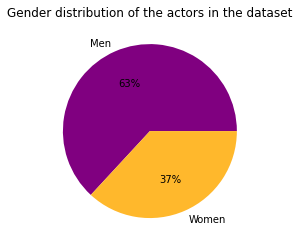

In [54]:
# Distribution of actors by gender
plt.title('Gender distribution of the actors in the dataset')
plt.pie(df_actors['actor_gender'].value_counts(), labels=['Men', 'Women'], autopct='%.0f%%', colors=[PURPLE, ORANGE])
plt.show()

There seem to be a different mean between both distributions (actors and casting genders). A T-test will be performed to know whether the mean is significantly different. As it is a binary column (Male or Female), binary values were attributed (0 for Male and 1 for Female).

In [55]:
stats.ttest_ind(df_chars.actor_gender.dropna().apply(lambda x: 1 if x=='F' else 0), df_actors.actor_gender.dropna().apply(lambda x: 1 if x=='F' else 0))

Ttest_indResult(statistic=-21.264029167543427, pvalue=2.7090640167577916e-100)

The p-value of the t-test being really close to 0, there is a significant difference in the distribution. The value of the t-test being largely negative (-21.2), it means that there are significally less women in average in the casting than in the actors. It means that women are less represented in movies than men, regardless of the initial proportion of women and men in the actor set.

#### Actors birthdate

In [56]:
nb_actors_with_dob = df_actors['actor_dob'].count()
print("There are {} actors with a known birthdate, which represents {:.2f}% of the actors.".format(nb_actors_with_dob, nb_actors_with_dob/nb_actors*100))

There are 58336 actors with a known birthdate, which represents 43.30% of the actors.


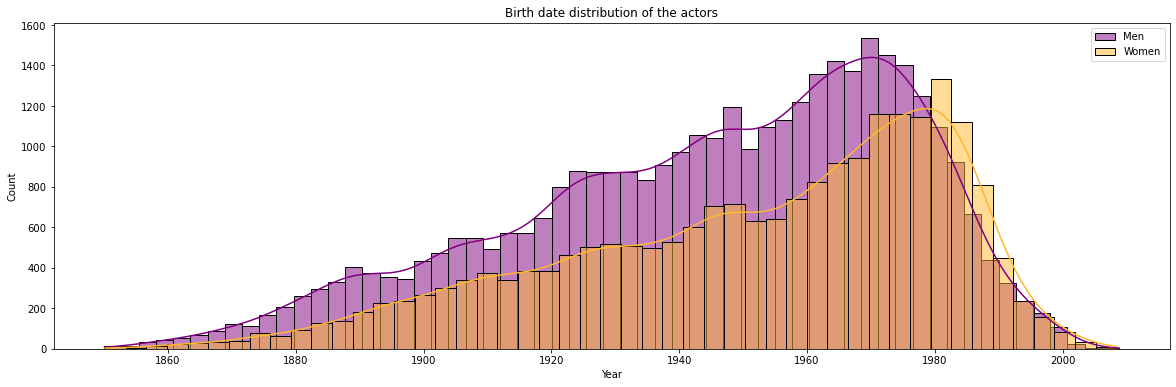

In [57]:
plt.figure(figsize=(20,6))
sns.histplot(df_actors[df_actors.actor_gender == 'M'].actor_dob, color=PURPLE, kde=True, label="Men")
sns.histplot(df_actors[df_actors.actor_gender == 'F'].actor_dob, color=ORANGE, kde=True, label="Women")
plt.title("Birth date distribution of the actors")
plt.xlabel("Year")
plt.ylabel("Count")
plt.legend()
plt.show()

#### Character ethnicity

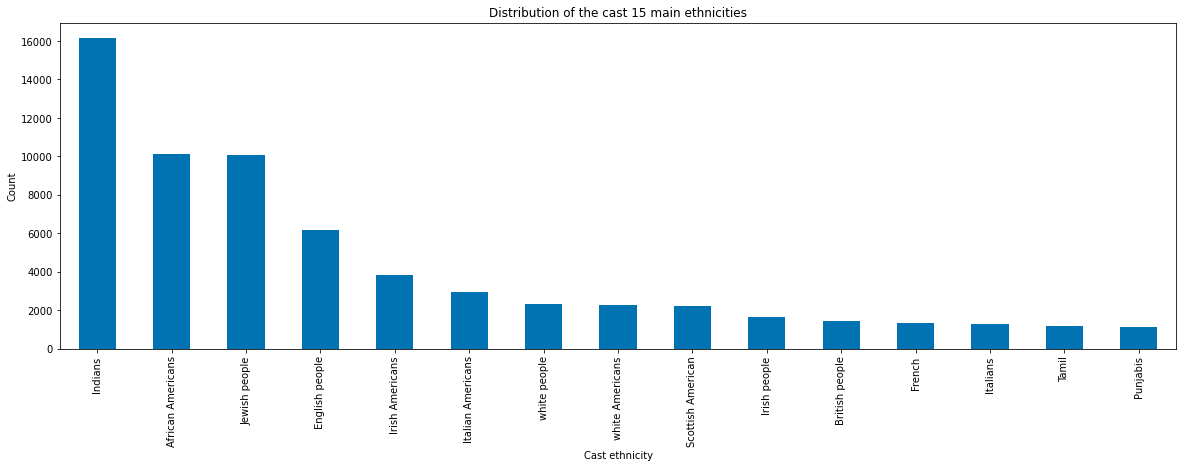

In [58]:
plt.figure(figsize=(20, 6))
nb = 15
df_chars['actor_ethnicity'].value_counts()[:nb].plot(kind='bar', color=BLUE)
plt.ylabel("Count")
plt.xlabel("Cast ethnicity")
plt.title("Distribution of the cast {} main ethnicities".format(nb))
plt.show()

#### Actor ethnicity

In [59]:
nb_actors_with_ethnicity = df_actors['actor_ethnicity'].value_counts().sum()
print("There are {} actors with a known ethnicity, which represents {:.2f}% of the actors.".format(nb_actors_with_ethnicity, nb_actors_with_ethnicity/nb_actors*100))

There are 7859 actors with a known ethnicity, which represents 5.83% of the actors.


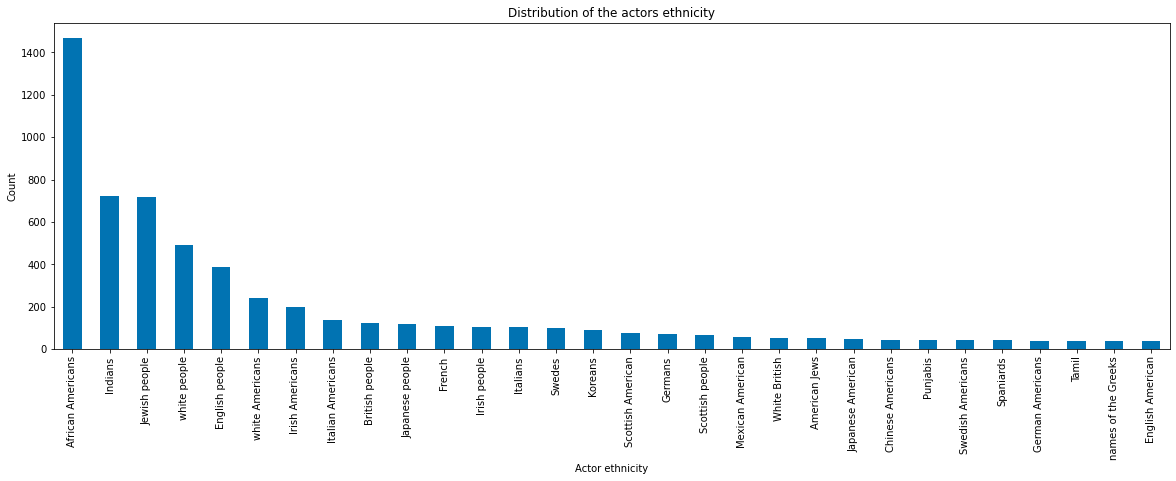

In [60]:
plt.figure(figsize=(20, 6))
df_actors['actor_ethnicity'].value_counts()[:30].plot(kind='bar', color=BLUE)
plt.ylabel("Count")
plt.xlabel("Actor ethnicity")
plt.title("Distribution of the actors ethnicity")
plt.show()

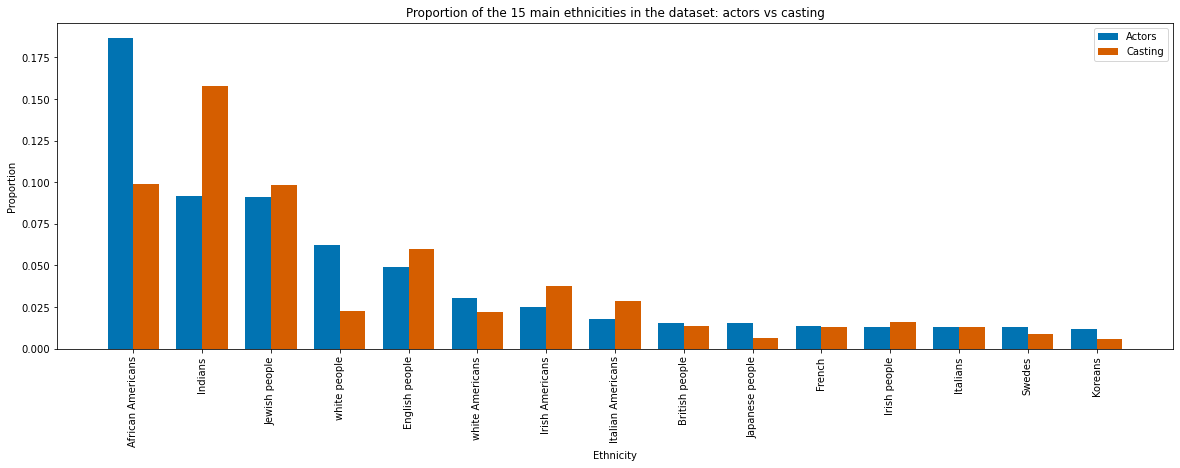

In [61]:
plt.figure(figsize=(20, 6))
nb = 15
X_axis = np.linspace(0, nb, nb)
plt.bar(X_axis - 0.2, (df_actors['actor_ethnicity'].value_counts()[:nb]/df_actors['actor_ethnicity'].count()).values, 0.4, label = 'Actors', color=BLUE)
plt.bar(X_axis + 0.2, (df_chars['actor_ethnicity'].value_counts()[df_actors['actor_ethnicity'].value_counts()[:nb].index]/df_chars['actor_ethnicity'].count()).values, 0.4, label = 'Casting', color=RED)

plt.xticks(X_axis, df_actors['actor_ethnicity'].value_counts()[:nb].index, rotation=90)
plt.ylabel("Proportion")
plt.xlabel("Ethnicity")
plt.title("Proportion of the {} main ethnicities in the dataset: actors vs casting".format(nb))
plt.legend()
plt.show()

As shown in the graph above, there seem to be a difference in the distribution of the African Americans and Indians ethnicities, regarding actors and casting. It will be confirmed or infirmed using a t-test.

In [62]:
stats.ttest_ind(df_actors['actor_ethnicity'].dropna().apply(lambda x: 1 if x == 'African Americans' else 0), df_chars['actor_ethnicity'].dropna().apply(lambda x: 1 if x == 'African Americans' else 0))

Ttest_indResult(statistic=24.404763192726676, pvalue=3.4059879073765376e-131)

In [63]:
stats.ttest_ind(df_actors['actor_ethnicity'].dropna().apply(lambda x: 1 if x == 'Indians' else 0), df_chars['actor_ethnicity'].dropna().apply(lambda x: 1 if x == 'Indians' else 0))

Ttest_indResult(statistic=-15.72295704055784, pvalue=1.210783846406092e-55)

It could be deduced that African Americans actors play in average less in movies than Indian actors. However, there is around 6% of the actors with a known ethnicity. It that way, there is too few data to conclude anything as there are too many actors for which the ethnicity is unknown.

For the following, actor ethnicity won't be taken into account when studying actor relationship as there is too few data available.

#### Actors role distribution

In [64]:
cnt_m = df_chars[df_chars.actor_gender == "M"].groupby(['actor_name', 'actor_dob']).nunique().sort_values('wikipedia_m_ID', ascending=False)[['wikipedia_m_ID', 'character_name']].reset_index()
cnt_w = df_chars[df_chars.actor_gender == "F"].groupby(['actor_name', 'actor_dob']).nunique().sort_values('wikipedia_m_ID', ascending=False)[['wikipedia_m_ID', 'character_name']].reset_index()

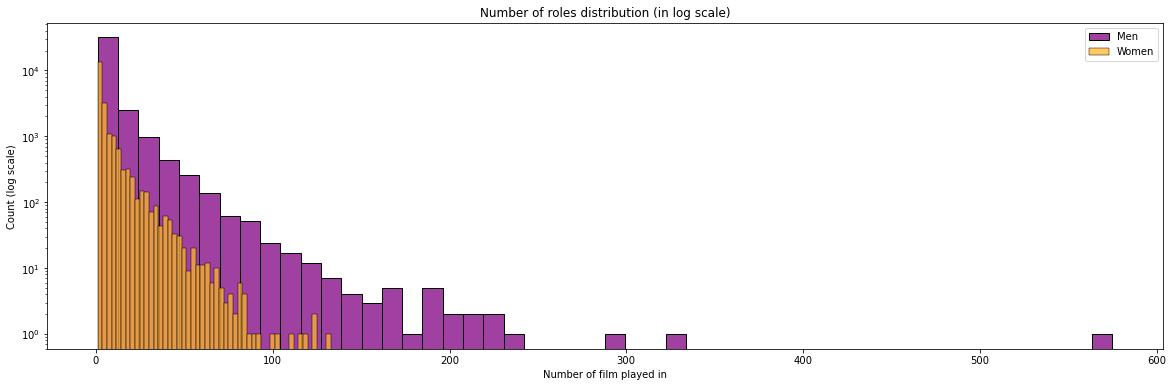

In [65]:
plt.figure(figsize=(20,6))
sns.histplot(cnt_m['wikipedia_m_ID'], log_scale=(False, True), bins=50, color=PURPLE, label="Men")
sns.histplot(cnt_w['wikipedia_m_ID'], log_scale=(False, True), bins=50, color=ORANGE, label="Women")
plt.xlabel("Number of film played in")
plt.title("Number of roles distribution (in log scale)")
plt.ylabel("Count (log scale)")
plt.legend()
plt.show()

As we can see, there is quite some disparity in the dataset between the number of movies and characters for a single actor. This is explained for some actors like Dharmendra Deol by having a lot of null values in the character name column (maybe due to bad char encoding choice). For others like Mel Blanc, (who was a voice actor) this is explained by having played some characters in different films like Buggs Bunny for example. Also, as he only was a voice actor, he is mentionned many times for the same film.

#### Time between first and last performance

In [66]:
careers = df_chars[['wikipedia_m_ID', 'actor_name', 'actor_gender', 'actor_age']].groupby('actor_name', dropna=False).agg({'actor_age': ['mean', 'min', 'max', 'count'], 'actor_gender': ['first']}).reset_index()
careers['duration'] = careers.actor_age['max'] - careers.actor_age['min']

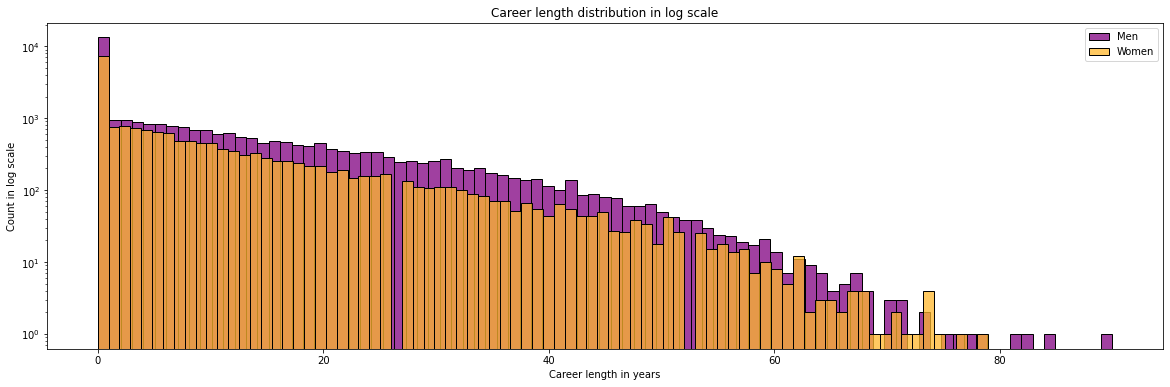

In [67]:
plt.figure(figsize=(20, 6))
sns.histplot(careers[careers.actor_gender['first'] == "M"]['duration'], log_scale=(False, True), color=PURPLE, label="Men")
sns.histplot(careers[careers.actor_gender['first'] == "F"]['duration'], log_scale=(False, True), color=ORANGE, label="Women")
plt.xlabel("Career length in years")
plt.ylabel("Count in log scale")
plt.title("Career length distribution in log scale")
plt.legend()
plt.show()

#### Age distribution for first and last movie

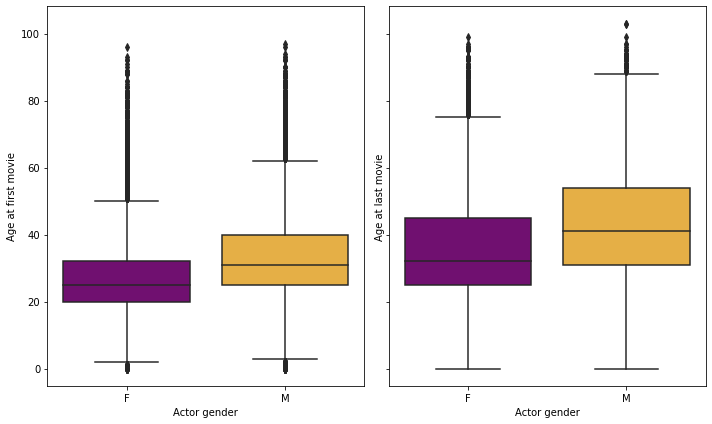

In [68]:
fig, axs = plt.subplots(1, 2, figsize=(10, 6), sharey='all')

sns.boxplot(x=careers.actor_gender['first'], y=careers.actor_age["min"], ax=axs[0], palette=[PURPLE, ORANGE])
sns.boxplot(x=careers.actor_gender['first'], y=careers.actor_age["max"], ax=axs[1], palette=[PURPLE, ORANGE])
axs[0].set_xlabel("Actor gender")
axs[1].set_xlabel("Actor gender")
axs[0].set_ylabel("Age at first movie")
axs[1].set_ylabel("Age at last movie")
plt.tight_layout()
plt.show()

As it can be seen, the spread of the values for the age of the first movies, compared to the one for the age of the last movie is greater. Actors tend to start their career at the more common age than end it.

#### Interaction between actors

In [69]:
# let's start in a subset first : year [1980, 1990)
date1 = datetime(1980, 1, 1)
date2 = datetime(1984, 12, 31)

selected_years = df_chars[df_chars.m_release_date.between(date1, date2)]

In [70]:
binom = pd.DataFrame()
# try and binomial
for elem in selected_years.wikipedia_m_ID.unique()[:1000]:
    tmp = selected_years[selected_years.wikipedia_m_ID == elem]
    tmp = pd.merge(tmp, tmp, 'cross', suffixes=("1","2"))
    tmp = tmp[tmp.actor_name1 > tmp.actor_name2]
    binom = pd.concat([binom, tmp])
binom = binom[['actor_name1', 'actor_name2', 'wikipedia_m_ID1']]
binom['weight'] = 1

In [71]:
# graph with interactions between actors. not very interesting, even when plotting only the GCC
G = nx.from_pandas_edgelist(binom, 'actor_name1', 'actor_name2')
largest_cc = max(nx.connected_components(G), key=len)
GCC = G.subgraph(largest_cc)

In [72]:
#_, axs = plt.subplots(1, 2, figsize=(20, 10))
#nx.draw(GCC, pos=nx.spring_layout(GCC), node_size=10, node_color=[(0., .8, 1, 0.24)] ,width=.1, ax=axs[0])
#nx.draw(GCC, pos=nx.kamada_kawai_layout(GCC), node_size=10, node_color=[(0., .8, 1, 0.24)] ,width=.1, ax=axs[1])
#axs[0].set_xlabel("Spring")
#axs[1].set_xlabel("Kamada-Kawai")
#plt.title("Giant connected components of co-acting interactions graph")
#plt.show()

As the code takes a while to run, the image has been preprocessed and is imported as a png.

![GCC](images/GCC_co_acting_example.png)

Even though we observe a pretty dense graph, it doesn't tell us much, as there is too much data to clearly see what is happening. We can however easily compute the edge to node ratio to get the average degree of a node. This roughly corresponds to the number of films an actor starred in, divided by the average number of actors per film.

The above graph shows the GCC for all the actors that have played in the 1000 first films. We used 2 different layouts, that both can highlight different graph properties. We can see on graph using the spring layout that there is a strongly connected component, and some outliers. The Kamada-Kawai additionally shows that there are a few hubs, i.e. nodes that connect the strongly connected to some outliers.

In [73]:
print("The edge to node ratio of the graph is {:.3f}".format(G.number_of_edges()/G.number_of_nodes()))

The edge to node ratio of the graph is 6.957


### 5.2 Movie general analysis

#### Movie name

In [74]:
nb_movies = df_movies[["m_name", "freebase_m_ID"]].value_counts().count()
unique_wikipedia_m_id = df_movies["wikipedia_m_ID"].count()
print("There are {} different movies, corresponding to {} different wikipedia ID.".format(nb_movies, unique_wikipedia_m_id))

There are 74269 different movies, corresponding to 74269 different wikipedia ID.


In [75]:
nb_duplicated_titles = df_movies[df_movies.duplicated('m_name', keep=False)]['wikipedia_m_ID'].count()
print("There are {} movies with duplicated titles.".format(nb_duplicated_titles))

There are 9411 movies with duplicated titles.


In [76]:
df_movies["m_name"].value_counts()

Macbeth                                       16
Alice in Wonderland                           14
Les Misérables                                13
A Christmas Carol                             13
Hamlet                                        11
                                              ..
Ek Se Bhale Do                                 1
Shinobido                                      1
The Eyes of Thailand                           1
Note by Note: The Making of Steinway L1037     1
Spliced                                        1
Name: m_name, Length: 68774, dtype: int64

One can see that when some movies have the same title, it mainly corresponds to either remake movies or common titles where movies have nothing in common.

#### Movie release date

In [77]:
nb_movies_with_release_date = df_movies['m_release_date'].dropna().count()
print("There are {} movies with a known release date. It corresponds to {:.2f} % of the movies.".format(nb_movies_with_release_date, nb_movies_with_release_date / nb_movies * 100))

There are 74269 movies with a known release date. It corresponds to 100.00 % of the movies.


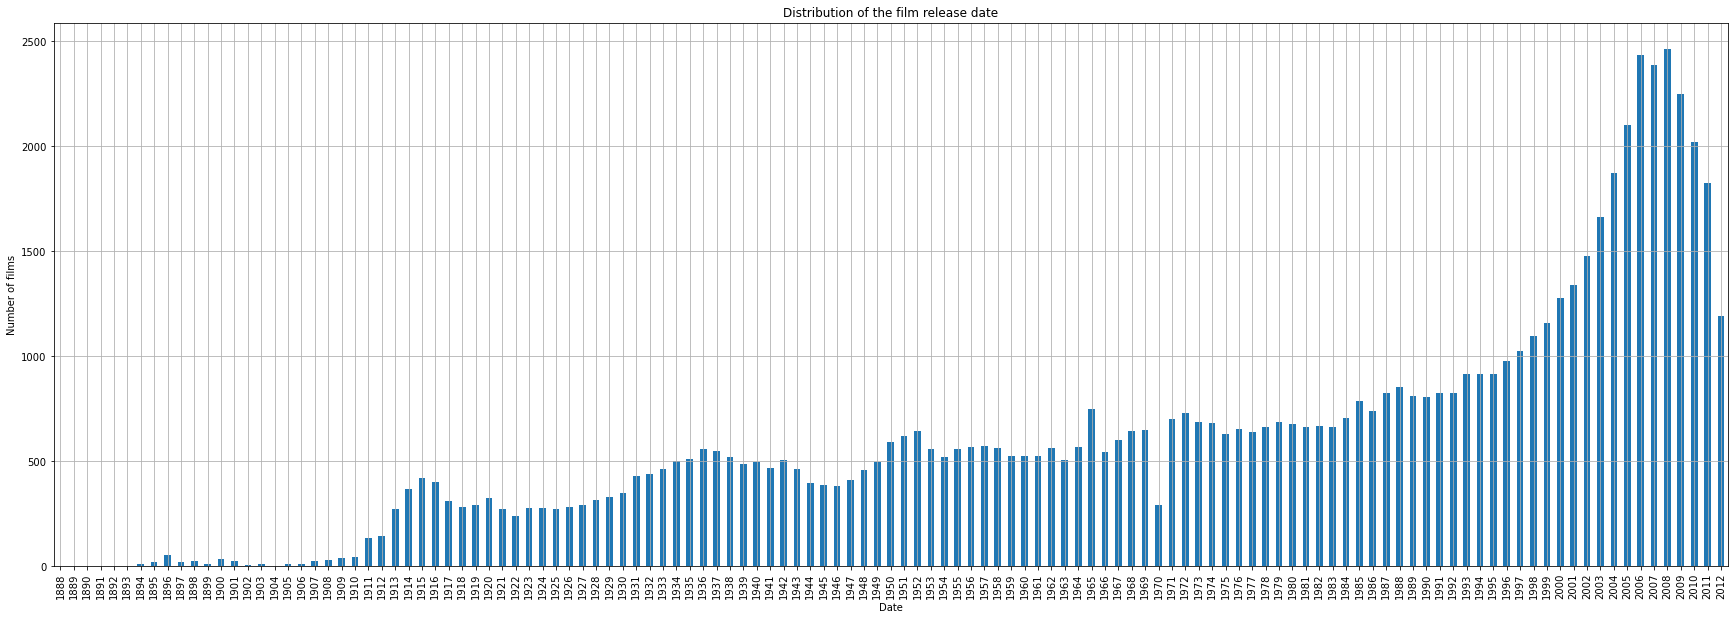

In [78]:
df_movies['m_release_date'].dropna().dt.year.sort_values().value_counts(sort=False).plot(kind='bar', figsize=(30,10))
plt.grid()
plt.title('Distribution of the film release date')
plt.xlabel('Date')
plt.ylabel('Number of films')
plt.show()

The dataset more movies for the last decades that for the 20th century. This is probably due to the digitalization that drastically reduced the cost of making a movie.  Going from magnetic tapes to hard drive is an example that had a huge impact on the movie industry.

#### Movie box office

In [79]:
nb_movies_with_BO = df_movies['m_BO_revenue'].dropna().count()
print("There are {} movies with a known box office revenue. It corresponds to {:.2f} % of the movies.".format(nb_movies_with_BO, nb_movies_with_BO / nb_movies * 100))

There are 8316 movies with a known box office revenue. It corresponds to 11.20 % of the movies.


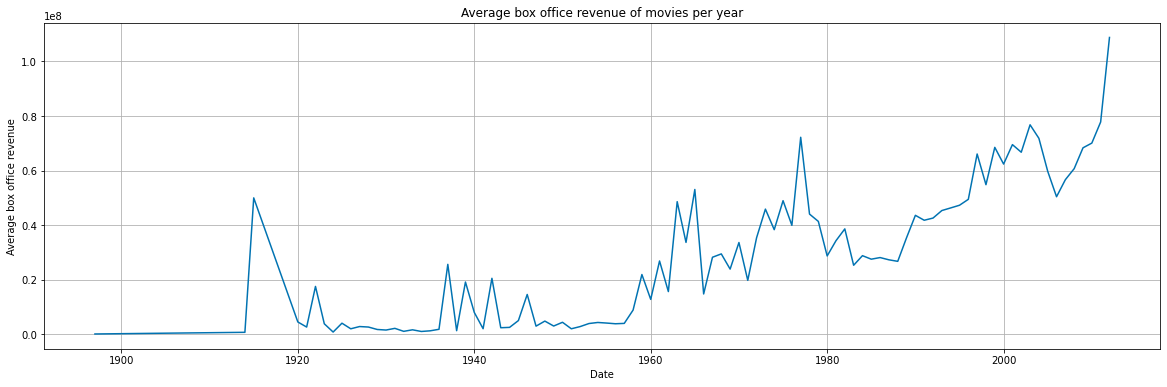

In [80]:
df_movies.groupby(df_movies.m_release_date.dt.year).mean()['m_BO_revenue'].dropna().plot(figsize=(20,6), color=BLUE)
plt.grid()
plt.xlabel('Date')
plt.ylabel('Average box office revenue')
plt.title('Average box office revenue of movies per year')
plt.show()

As one can see, the average box office revenue has increased in the last decades, going from 0.2e8 in the 60's, to over 1e8 in 2012.

#### Movie runtime

In [81]:
nb_movies_with_runtime = df_movies['m_runtime'].dropna().count()
print("There are {} movies with a known runtime duration. It corresponds to {:.2f} % of the movies.".format(nb_movies_with_runtime, nb_movies_with_runtime / nb_movies * 100))

There are 58348 movies with a known runtime duration. It corresponds to 78.56 % of the movies.


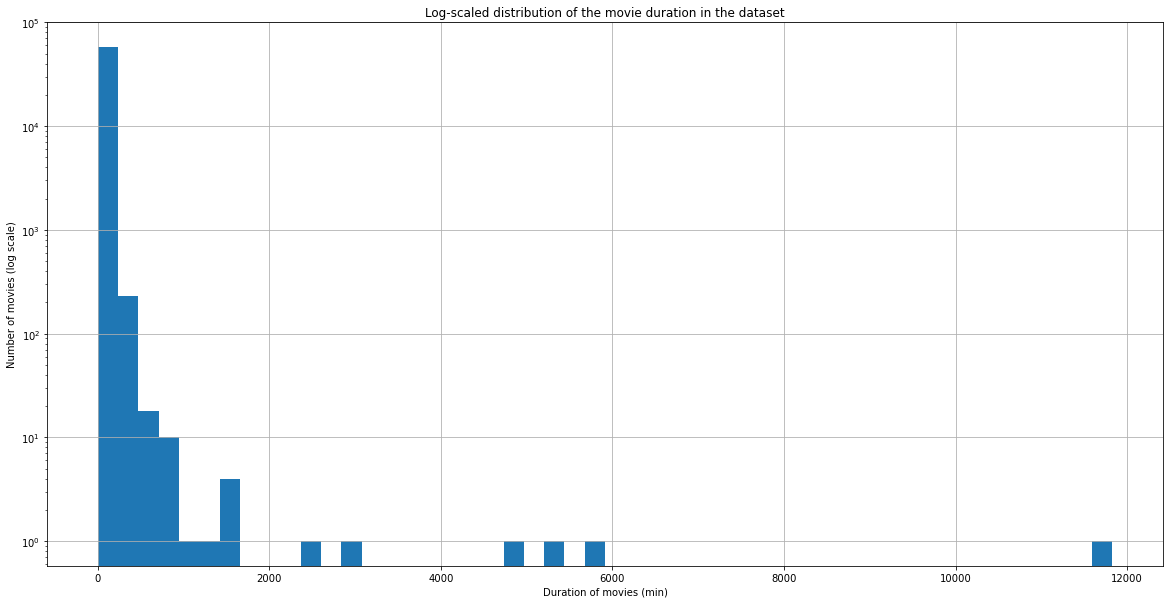

In [82]:
plt.figure(figsize=(20,10))
df_movies.m_runtime.hist(bins=50)
plt.yscale('log')
plt.ylabel('Number of movies (log scale)')
plt.xlabel('Duration of movies (min)')
plt.title("Log-scaled distribution of the movie duration in the dataset")
plt.show()

In [83]:
df_movies[df_movies['m_runtime'] >10000]

,wikipedia_m_ID,freebase_m_ID,m_name,m_release_date,m_BO_revenue,m_runtime,m_languages,m_countries,m_genres,m_languages_freebase_ID,m_countries_freebase_ID,m_genres_freebase_ID
71100,25345684,/m/09gqhh3,Cinématon,2011-01-01,NaN,11828.0,[French Language],[France],"[Experimental film, Documentary]",(/m/064_8sq),(/m/0f8l9c),"(/m/0424mc, /m/0jtdp)"


As it can be seen, the movie duration seem like a heavy-tailed distribution. There are some outliers, such as a movie called 'Cinémation' thats lasts more than 150 hours.

The average duration of a movie throughout the years is now studied. A bootstrap version is computed. 

In [84]:
def bootstrap_CI(data, nbr_draws):
    """
    Creates a bootstrap of the given data, with a confidence interval of 0.95.

    :param data: Data to bootstrap
    :param nbr_draws: number of draws, each draw having length of data number of samples
    :return: Values of 0.025 and 0.975 percentile of data, aka the confidence interval
    """
    means = np.zeros(nbr_draws)
    data = np.array(data)

    for n in range(nbr_draws):
        indices = np.random.randint(0, len(data), len(data))
        data_tmp = data[indices] 
        means[n] = np.nanmean(data_tmp)
    
    return [np.nanpercentile(means, 2.5),np.nanpercentile(means, 97.5)]

In [85]:
merge = df_movies.m_release_date.dt.year

stat = df_movies[df_movies['m_runtime']<5000][['m_release_date', 'm_runtime']].dropna().groupby(merge).apply(lambda x: pd.Series({
    'average_runtime': x['m_runtime'].mean(),
    'lower_err_runtime': bootstrap_CI(x['m_runtime'], 1000)[0],
    'upper_err_runtime': bootstrap_CI(x['m_runtime'], 1000)[1]
}))

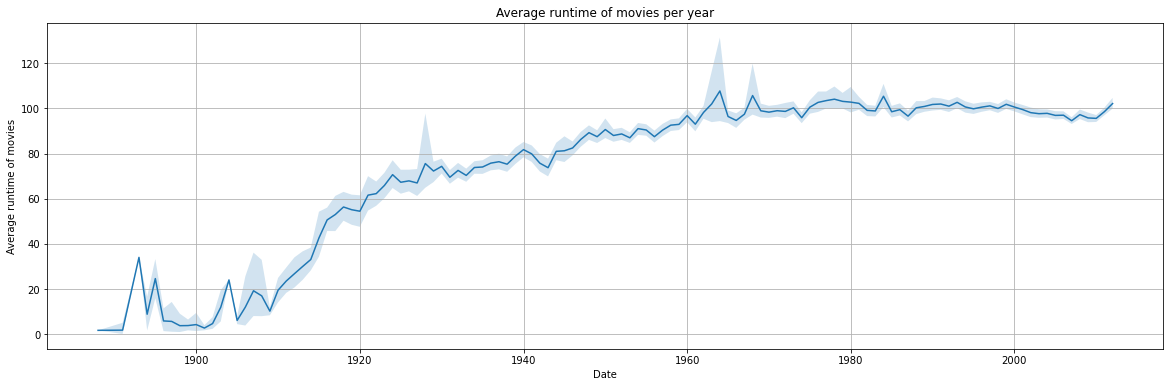

In [86]:
plt.figure(figsize=(20,6))

plt.fill_between(stat.index, stat.lower_err_runtime, stat.upper_err_runtime, alpha=0.2)
plt.plot(stat.average_runtime)
plt.xlabel('Date')
plt.grid()
plt.ylabel('Average runtime of movies')
plt.title('Average runtime of movies per year')
plt.show()

As it can be seen, the overall average runtime has increased in the last century, probably due to the technology improvement. However, it can be seen that there is no further increase in the last decades. This could be due to a trade-off film industry has found between the cost of producing a movie and revenue collected.

#### Box office revenue and movie runtime

In [87]:
df_temp = df_movies[['m_runtime', 'm_BO_revenue']].copy().dropna()
nb_movies_with_runtime_bo = df_temp['m_runtime'].count()
print("There are {} movies that have a known box office revenue and runtime, which represents {:.2f}% of the movies.".format(nb_movies_with_runtime_bo, nb_movies_with_runtime_bo/nb_movies*100))

There are 8231 movies that have a known box office revenue and runtime, which represents 11.08% of the movies.


It is studied whether there is a correlation between the movie runtime and the movie box office revenue. To do so, a pearson test is performed.

In [88]:
stats.spearmanr(df_temp['m_runtime'],df_temp['m_BO_revenue'])

SpearmanrResult(correlation=0.2921071400580362, pvalue=1.2803953905331009e-161)

In [89]:
stats.pearsonr(df_temp['m_runtime'],df_temp['m_BO_revenue'])

(0.18961800928066141, 1.7114238676934704e-67)

- Using spearman, there is a small (0.29), but significant (p < 0.05) positive correlation.
- Using pearsonr, there is a small (0.19), but significant (p < 0.05) positive correlation.

We saw on graphs above that movie runtime had an increasing trend over time, and same for box office revenue, hence a positive correlation is to expect. However both increases can be explained independently: it makes sense to see the runtime increase since the increase in technology made it possible to have longer movies. Also, the revenue of the movie industry is increasing, but this could be explained by inflation. This makes it too hard to conclude that there is a causality.

#### Movie genres

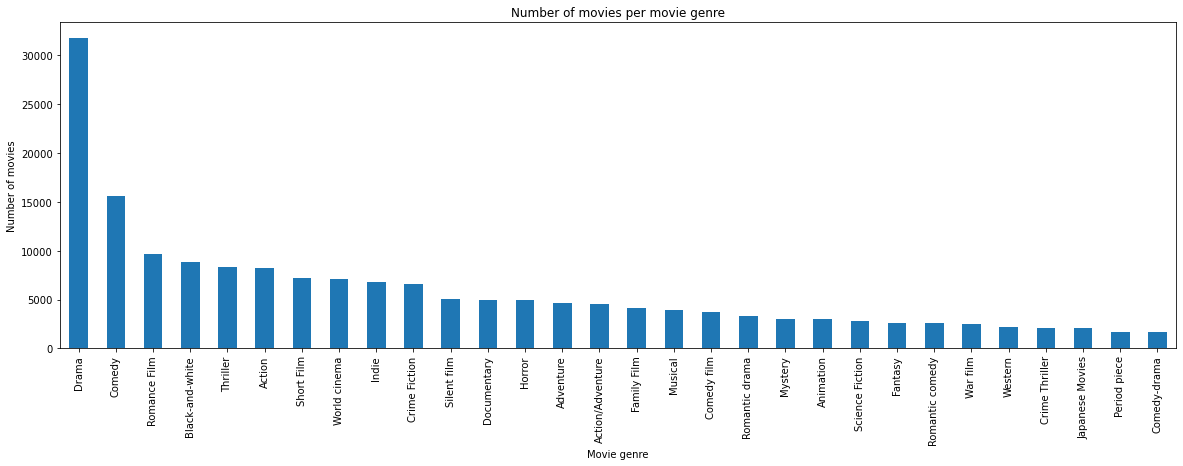

In [90]:
df_genres_m = df_movies.explode('m_genres').dropna(subset='m_genres')
df_genres_m['m_genres'].value_counts()[:30].plot(kind='bar', figsize=(20,6))
plt.title('Number of movies per movie genre')
plt.xlabel('Movie genre')
plt.ylabel('Number of movies')
plt.show()

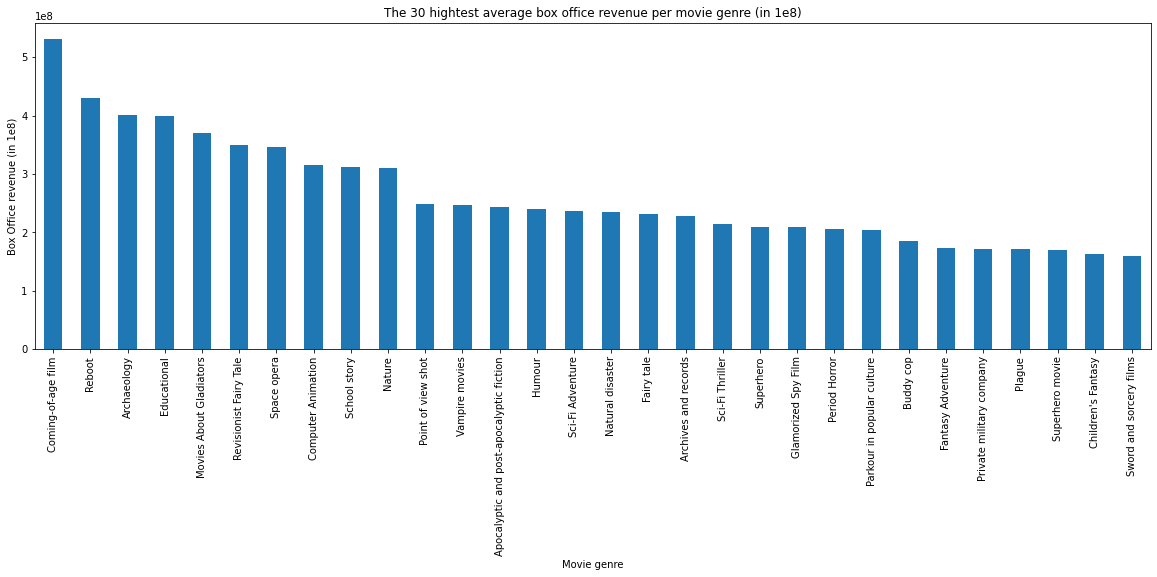

In [91]:
plt.figure(figsize=(20,6))
df_genres_m[["m_BO_revenue", "m_genres"]].dropna().groupby('m_genres')['m_BO_revenue'].mean().sort_values(ascending=False)[:30].plot(kind='bar')
plt.title('The 30 hightest average box office revenue per movie genre (in 1e8)')
plt.xlabel('Movie genre')
plt.ylabel('Box Office revenue (in 1e8)')
plt.show()

As it can be seen, the genres with the highest average box office revenue are not in the most common genres. To make a deeper analysis, it was decided to bootstrap the movies.

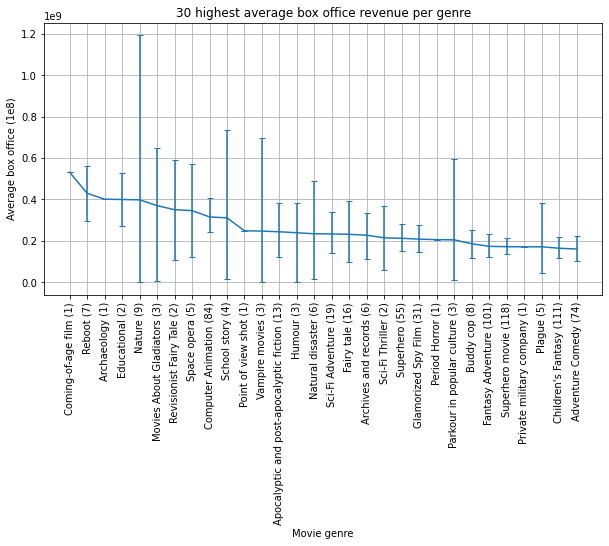

In [92]:
merge = 'm_genres'

stat = df_genres_m.dropna().groupby(merge).apply(lambda x: pd.Series({
    'average_bo': x['m_BO_revenue'].mean(),
    'lower_err_bo': bootstrap_CI(x['m_BO_revenue'], 1000)[0],
    'upper_err_bo': bootstrap_CI(x['m_BO_revenue'], 1000)[1]
}))

plt.figure(figsize=(10,5))
stat = stat.sort_values("average_bo", ascending=False)

labels = stat.index[:30]
labels_hist = df_genres_m.dropna(subset='m_BO_revenue')['m_genres'].value_counts()
labels_mapping = labels.map(labels_hist)
labels = [x + ' ({})'.format(labels_mapping[i]) for i, x in enumerate(labels)]

plt.errorbar(labels, stat.average_bo[:30],
         yerr = [-stat.lower_err_bo[:30] + stat.average_bo[:30], 
                -stat.average_bo[:30] + stat.upper_err_bo[:30]],
         capsize= 3)
plt.xlabel('Movie genre')
plt.xticks(rotation=90)
plt.ylabel('Average box office (1e8)')
plt.grid()
plt.title('30 highest average box office revenue per genre')
plt.show()

As it can be seen, the genres with the highest average box office revenue found are in general not the most common genres. This is probably due to the fact that most common genres contain movies where the box office was really low. This is also why the winner genre have a really low number of movies: they probably had one excellent movie.

In [93]:
df_genre_a= df_genres_m.merge(df_chars, left_on='wikipedia_m_ID', right_on='wikipedia_m_ID').dropna()

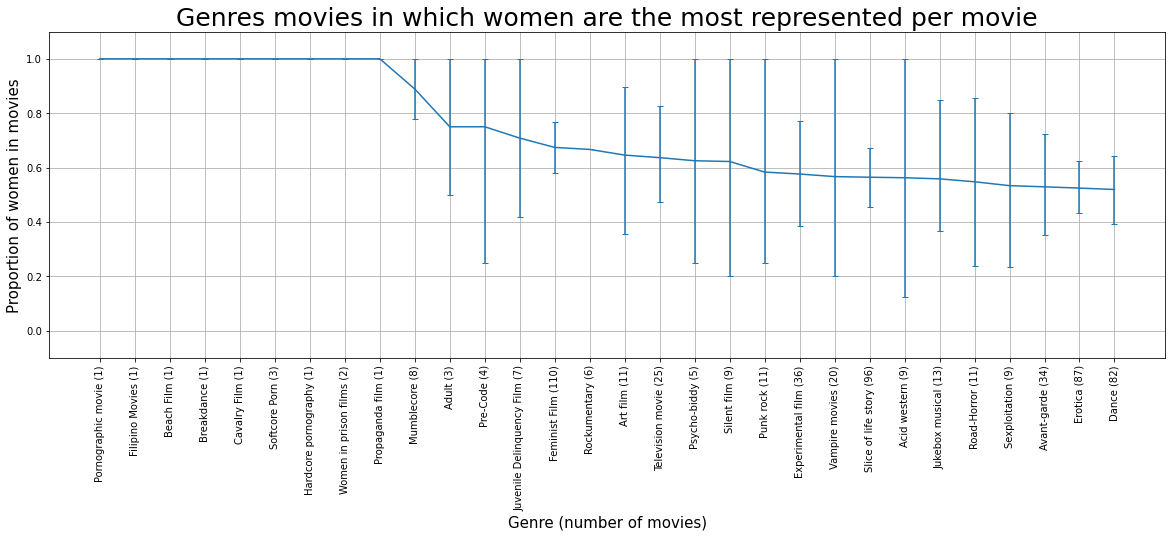

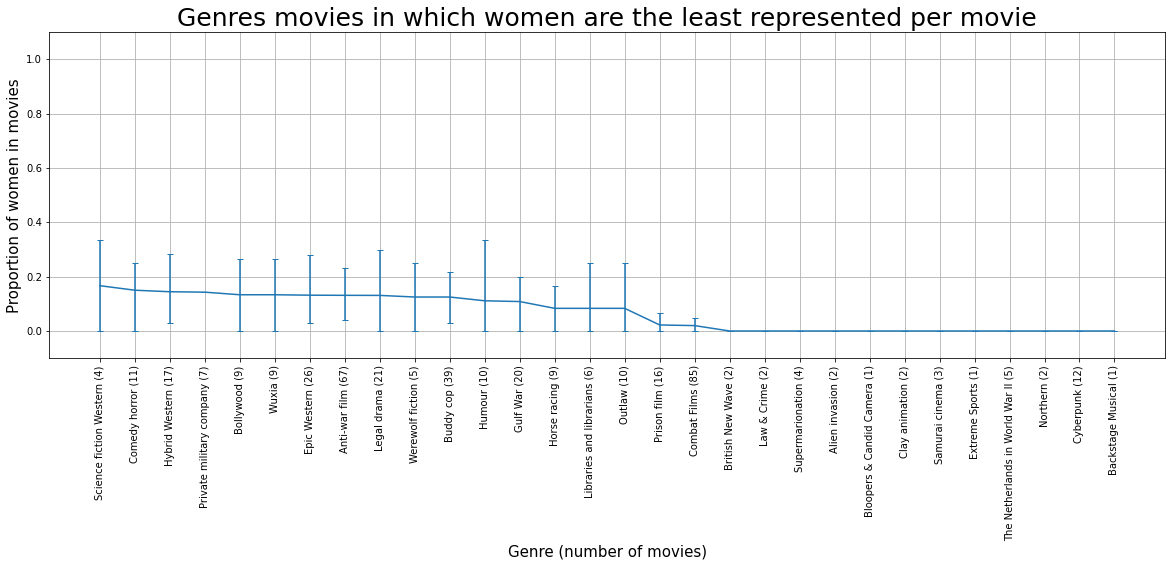

In [94]:
merge = ['m_genres']

df_temp = df_genre_a[['wikipedia_m_ID', 'm_genres', 'actor_gender']].copy()

df_temp['actor_gender'] = df_temp['actor_gender'].apply(lambda x: 1 if x=='F' else 0)

stat = df_temp.dropna(subset=['actor_gender', 'm_genres']).groupby(['m_genres', 'wikipedia_m_ID']).mean().groupby(merge).apply(lambda x: pd.Series({
    'average_gender': x['actor_gender'].mean(),
    'lower_err_gender': bootstrap_CI(x['actor_gender'], 1000)[0],
    'upper_err_gender': bootstrap_CI(x['actor_gender'], 1000)[1]
}))

n = 30

plt.figure(figsize=(20,6))
stat = stat.sort_values("average_gender", ascending=False)

labels = stat.index[:n]
labels_hist = df_temp.dropna(subset='actor_gender')['m_genres'].value_counts()
labels_mapping = labels.map(labels_hist)
labels = [x + ' ({})'.format(labels_mapping[i]) for i, x in enumerate(labels)]

plt.errorbar(labels, stat.average_gender[:n],
         yerr = [-stat.lower_err_gender[:n] + stat.average_gender[:n], 
                -stat.average_gender[:n] + stat.upper_err_gender[:n]],
         capsize= 3)

plt.ylim(-0.1, 1.1)
plt.grid()
plt.xticks(rotation=90)
plt.xlabel('Genre (number of movies)', fontsize=15)
plt.ylabel('Proportion of women in movies', fontsize=15)
plt.title('Genres movies in which women are the most represented per movie', fontsize=25)
plt.show()

plt.figure(figsize=(20,6))
stat = stat.sort_values("average_gender", ascending=False)

labels = stat.index[-n:]
labels_hist = df_temp.dropna(subset='actor_gender')['m_genres'].value_counts()
labels_mapping = labels.map(labels_hist)
labels = [x + ' ({})'.format(labels_mapping[i]) for i, x in enumerate(labels)]

plt.errorbar(labels, stat.average_gender[-n:],
         yerr = [-stat.lower_err_gender[-n:] + stat.average_gender[-n:], 
                -stat.average_gender[-n:] + stat.upper_err_gender[-n:]],
         capsize= 3)

plt.xticks(rotation=90)
plt.ylim(-0.1, 1.1)
plt.grid()
plt.xlabel('Genre (number of movies)', fontsize=15)
plt.ylabel('Proportion of women in movies', fontsize=15)
plt.title('Genres movies in which women are the least represented per movie', fontsize=25)
plt.show()

#### Country of production

In [95]:
df_countries_m = df_movies.explode('m_countries').dropna(subset='m_countries')
nb_unique_countries = df_countries_m['m_countries'].nunique()
print("There are {} different countries present in the dataset.".format(nb_unique_countries))

There are 146 different countries present in the dataset.


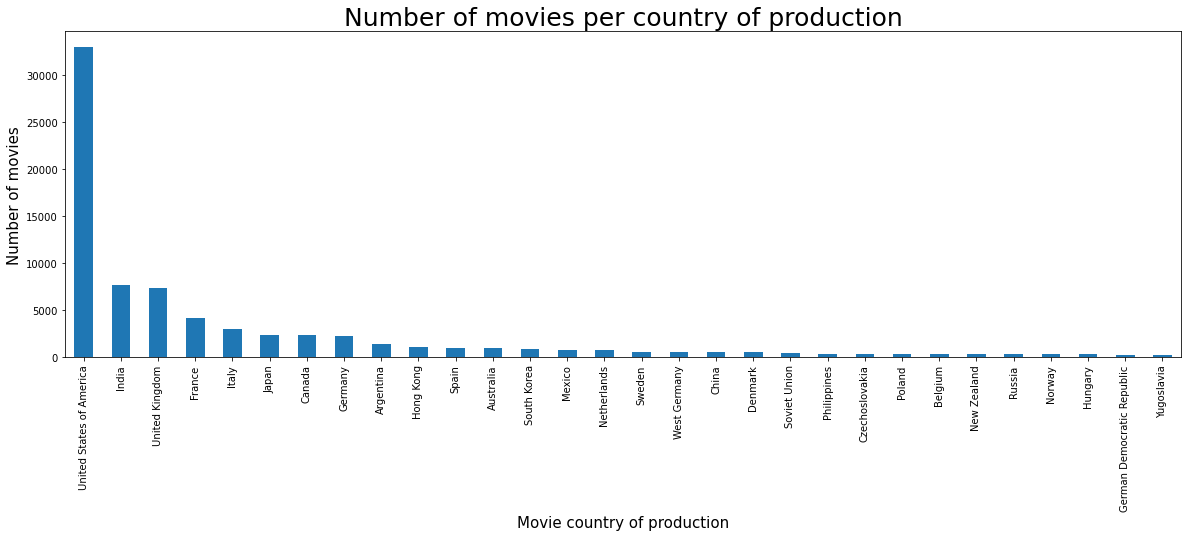

In [96]:
df_countries_m['m_countries'].value_counts()[:30].plot(kind='bar', figsize=(20,6))
plt.title('Number of movies per country of production', fontsize = 25)
plt.xlabel('Movie country of production', fontsize = 15)
plt.ylabel('Number of movies', fontsize = 15)
plt.show()

In [97]:
nb_movies_with_countries = df_countries_m.dropna(subset='m_countries')['wikipedia_m_ID'].nunique()
print("There are {} movies with a known country of production. It corresponds to {:.2f} % of the movies.".format(nb_movies_with_countries, nb_movies_with_countries / nb_movies * 100))

There are 69089 movies with a known country of production. It corresponds to 93.03 % of the movies.


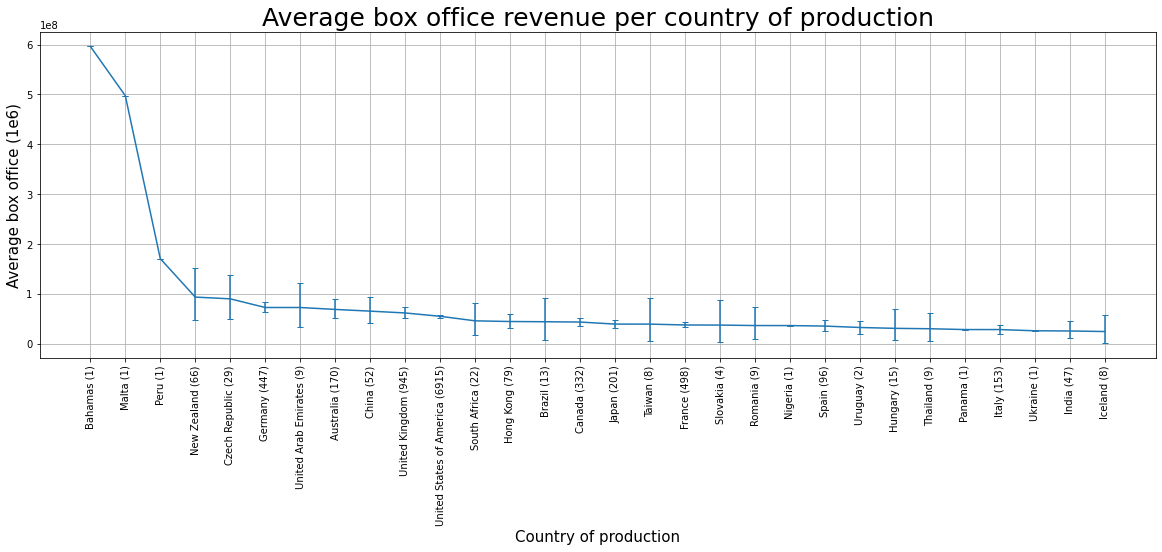

In [98]:
merge = 'm_countries'

stat = df_countries_m.dropna(subset=['m_BO_revenue', 'm_countries']).groupby(merge).apply(lambda x: pd.Series({
    'average_bo': x['m_BO_revenue'].mean(),
    'lower_err_bo': bootstrap_CI(x['m_BO_revenue'], 1000)[0],
    'upper_err_bo': bootstrap_CI(x['m_BO_revenue'], 1000)[1]
}))

plt.figure(figsize=(20,6))
stat = stat.sort_values("average_bo", ascending=False)

labels = stat.index[:30]
labels_hist = df_countries_m.dropna(subset='m_BO_revenue')['m_countries'].value_counts()
labels_mapping = labels.map(labels_hist)
labels = [x + ' ({})'.format(labels_mapping[i]) for i, x in enumerate(labels)]

plt.errorbar(labels, stat.average_bo[:30],
         yerr = [-stat.lower_err_bo[:30] + stat.average_bo[:30], 
                -stat.average_bo[:30] + stat.upper_err_bo[:30]],
         capsize= 3)
plt.xlabel('Country of production', fontsize=15)
plt.xticks(rotation=90)
plt.ylabel('Average box office (1e6)', fontsize=15)
plt.grid()
plt.title('Average box office revenue per country of production', fontsize=25)
plt.show()

#### Movie languages

In [99]:
df_languages_m = df_movies.explode('m_languages').dropna(subset='m_languages')
nb_unique_languages = df_languages_m['m_languages'].nunique()
print("There are {} different languages present in the dataset.".format(nb_unique_languages))

There are 204 different languages present in the dataset.


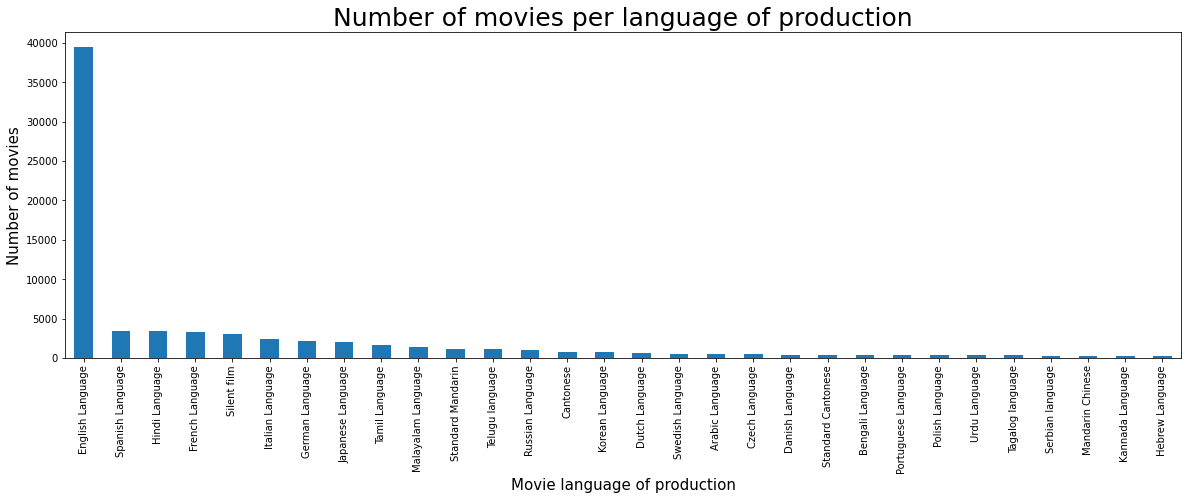

In [100]:
df_languages_m['m_languages'].value_counts()[:30].plot(kind='bar', figsize=(20,6))
plt.title('Number of movies per language of production', fontsize = 25)
plt.xlabel('Movie language of production', fontsize = 15)
plt.ylabel('Number of movies', fontsize = 15)
plt.show()

In [101]:
nb_value_BO_english = df_languages_m.dropna(subset='m_BO_revenue')['m_languages'].value_counts()['English Language']
print("English language movies with known box office revenue represent {:.2f}% of all the movies with a known box office revenue.".format(nb_value_BO_english/nb_movies_with_BO *100))

English language movies with known box office revenue represent 88.72% of all the movies with a known box office revenue.


### 5.3 Zoom on American movies

In [102]:
df_movies_USA = df_countries_m[df_countries_m['m_countries']=='United States of America']
df_m_a = df_movies_USA.merge(df_chars, left_on=['wikipedia_m_ID', 'm_release_date', 'freebase_m_ID'], right_on=['wikipedia_m_ID', 'm_release_date', 'freebase_m_ID'])

#### Movie runtime

In [103]:
nb_movies_US_with_runtime = df_movies_USA['m_runtime'].dropna().count()
nb_movies_with_runtime = df_movies['m_runtime'].dropna().count()
print("There are {} american movies with a known runtime, with represents {:.2f}% of the total movies with known runtime.".format(nb_movies_US_with_runtime, nb_movies_US_with_runtime/nb_movies_with_runtime*100))

There are 28975 american movies with a known runtime, with represents 49.66% of the total movies with known runtime.


In [104]:
runtime_US_mean = df_movies_USA['m_runtime'].mean()
print("American movies have an average runtime of {:.2f} min.".format(runtime_US_mean))

American movies have an average runtime of 88.07 min.


In [105]:
runtime_mean = df_movies['m_runtime'].mean()
print("All movies have an average runtime of {:.2f} min.".format(runtime_mean))

All movies have an average runtime of 94.07 min.


It is studied whether there is a significant difference in the average runtime between american movies and all movies.

In [106]:
stats.ttest_ind(df_movies_USA['m_runtime'].dropna(), df_movies['m_runtime'].dropna())

Ttest_indResult(statistic=-12.586358716581094, pvalue=2.6990386129039377e-36)

As p is smaller than 0.05, we can reject the null hypothesis that the distribution of runtime is the same, the mean of american runtimes is significantly smaller than the global one.

#### Movie box office revenue

In [107]:
nb_value_BO_USA = df_movies_USA['m_BO_revenue'].count()
print("American movies with known box office revenue represent {:.2f}% of all the movies with a known box office revenue.".format(nb_value_BO_USA/nb_movies_with_BO *100))

American movies with known box office revenue represent 83.15% of all the movies with a known box office revenue.


#### Movie genres

In [108]:
df_genres_m_USA = df_movies_USA.explode('m_genres')

In [109]:
nb_genres_USA = df_genres_m_USA['m_genres'].nunique()
print("There are {} different genre in american movies.".format(nb_genres_USA))

There are 341 different genre in american movies.


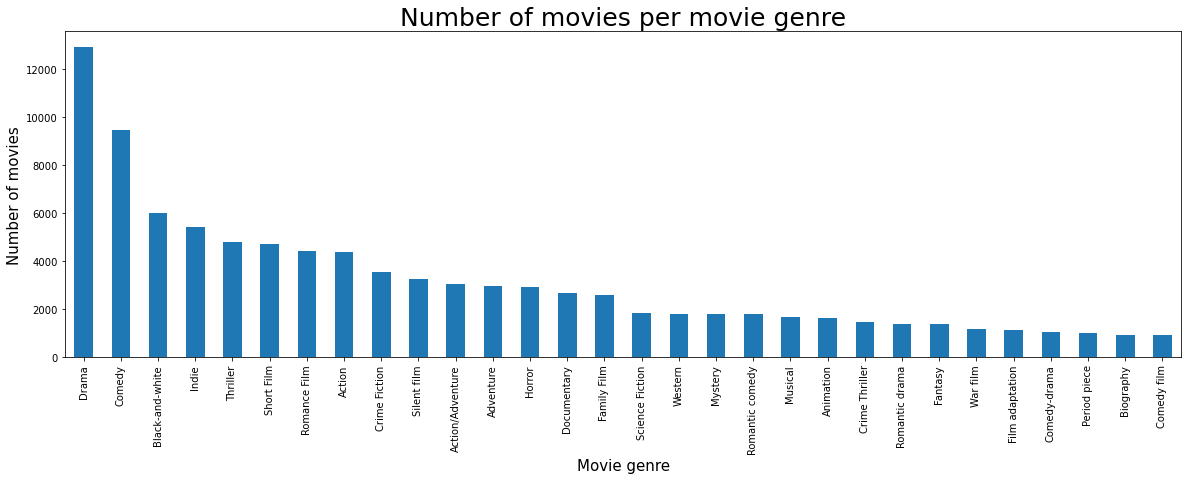

In [110]:
plt.figure(figsize=(20,6))
df_genres_m_USA['m_genres'].value_counts()[:30].plot(kind='bar', figsize=(20,6))
plt.title('Number of movies per movie genre', fontsize = 25)
plt.xlabel('Movie genre', fontsize = 15)
plt.ylabel('Number of movies', fontsize = 15)
plt.show()

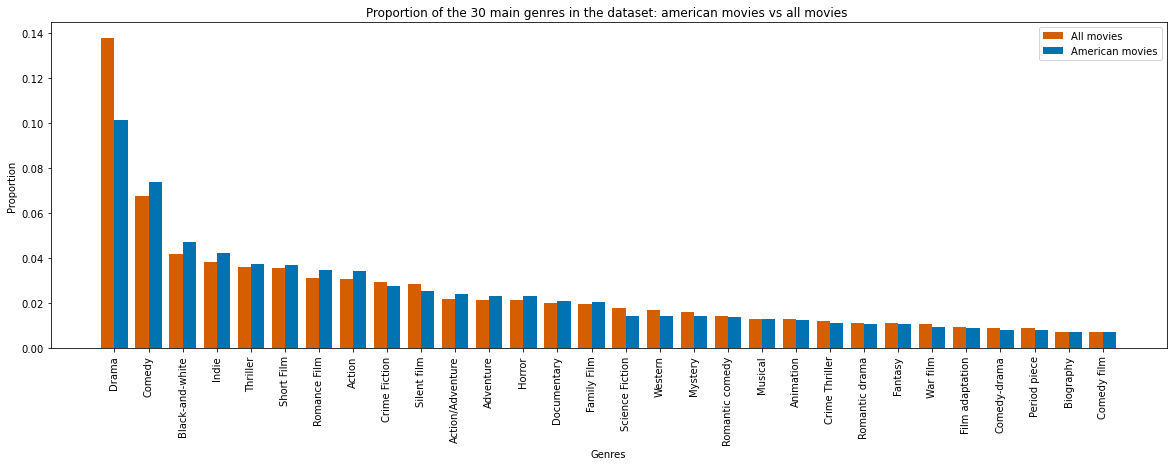

In [111]:
plt.figure(figsize=(20, 6))
nb = 30
X_axis = np.linspace(0, nb, nb)
plt.bar(X_axis - 0.2, (df_genres_m['m_genres'].value_counts()[df_genres_m['m_genres'].value_counts()[:nb].index]/df_genres_m['m_genres'].count()).values, 0.4, label = 'All movies', color=RED)
plt.bar(X_axis + 0.2, (df_genres_m_USA['m_genres'].value_counts()[:nb]/df_genres_m_USA['m_genres'].count()).values, 0.4, label = 'American movies', color=BLUE)

plt.xticks(X_axis, df_genres_m_USA['m_genres'].value_counts()[:nb].index, rotation=90)
plt.ylabel("Proportion")
plt.xlabel("Genres")
plt.title("Proportion of the {} main genres in the dataset: american movies vs all movies ".format(nb))
plt.legend()
plt.show()

As it can be seen, the proportion of genres when comparing american movies and global movies is roughly equivalent.

####  PCA on movie genre

In [112]:
def one_hot_encoding(df, col):
    y = pd.get_dummies(df[col])
    return y, y.columns

In [113]:
one_hot, genres_one_hot_labels = one_hot_encoding(df_genres_m_USA, 'm_genres')
df_USA_genres_one_hot = pd.concat([df_genres_m_USA, one_hot], axis=1)
df_USA_genres_one_hot = df_USA_genres_one_hot.groupby('wikipedia_m_ID')[genres_one_hot_labels].sum()

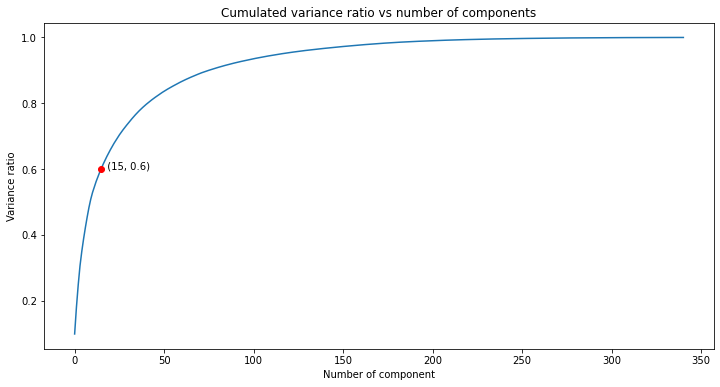

In [114]:
n=nb_genres_USA
scaler = MinMaxScaler()
X_features = scaler.fit_transform(df_USA_genres_one_hot)
pca = PCA(n)
pca.fit(X_features)
pca_variance = pca.explained_variance_
pca_variance_ratio = pca.explained_variance_ratio_

csum = np.cumsum(pca_variance_ratio)
plt.figure(figsize=(12, 6))
plt.plot(csum)
plt.plot(15, 0.6, marker='o', color='red') 
plt.ylabel('Variance ratio')
plt.xlabel('Number of component')
plt.title('Cumulated variance ratio vs number of components')
plt.text(15, 0.6, '  ({}, {})'.format(15, 0.6))
plt.show()

The PCA shows that we can significantly reduce the number of genres. The following code is a work-in-progress to make analysis on genres and grasp the similarities and differences between genres.

It was decided to keep 15 features in order to get 60% of the cumulated variance.

In [115]:
n=15
scaler = StandardScaler()
X_features = scaler.fit_transform(df_USA_genres_one_hot)
pca = PCA(n)
pca.fit_transform(X_features)
pca_variance = pca.explained_variance_

In [116]:
# number of components
n_pcs = pca.components_.shape[0]

best_four_important = []
most_important_names = []
n_best = 4
initial_feature_names = genres_one_hot_labels
for i in range(n_pcs):
    elts = np.argsort((pca.components_[i]))[::-1][:n_best]
    best_four_important.append(elts)
    most_important_names.append([initial_feature_names[elts[i]] for i in range(n_best)])

In [117]:
new_space = pca.transform(df_USA_genres_one_hot.values)
new_space = new_space.argmax(axis=1)

df_USA_genres_one_hot['m_genre_PCA'] = new_space
df_USA_genres_one_hot['m_genre_PCA'] = df_USA_genres_one_hot['m_genre_PCA'].apply(lambda x: ", ".join(most_important_names[x]))

In [118]:
df_movies_USA_genre_PCA = df_movies_USA.merge(df_USA_genres_one_hot[['m_genre_PCA']], left_on='wikipedia_m_ID', right_on='wikipedia_m_ID')
df_movies_USA_genre_PCA.head()

,wikipedia_m_ID,freebase_m_ID,m_name,m_release_date,m_BO_revenue,m_runtime,m_languages,m_countries,m_genres,m_languages_freebase_ID,m_countries_freebase_ID,m_genres_freebase_ID,m_genre_PCA
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English Language],United States of America,"[Thriller, Science Fiction, Horror, Adventure,...",(/m/02h40lc),(/m/09c7w0),"(/m/01jfsb, /m/06n90, /m/03npn, /m/03k9fj, /m/...","Thriller, Crime Thriller, Action, Mystery"
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,[English Language],United States of America,"[Mystery, Biographical film, Drama, Crime Drama]",(/m/02h40lc),(/m/09c7w0),"(/m/02n4kr, /m/03bxz7, /m/07s9rl0, /m/0hj3n01)","Mystery, Horror, Children's/Family, Drama"
2,13696889,/m/03cfc81,The Gangsters,1913-05-29,NaN,35.0,"[Silent film, English Language]",United States of America,"[Short Film, Silent film, Indie, Black-and-whi...","(/m/06ppq, /m/02h40lc)",(/m/09c7w0),"(/m/02hmvc, /m/06ppq, /m/0219x_, /m/01g6gs, /m...","Detective fiction, Detective, Sword and sorcer..."
3,10408933,/m/02qc0j7,Alexander's Ragtime Band,1938-08-16,3600000.0,106.0,[English Language],United States of America,"[Musical, Comedy, Black-and-white]",(/m/02h40lc),(/m/09c7w0),"(/m/04t36, /m/01z4y, /m/01g6gs)","Detective fiction, Detective, Sword and sorcer..."
4,175026,/m/017n1p,Sarah and Son,1930-01-01,NaN,86.0,[English Language],United States of America,"[Drama, Black-and-white]",(/m/02h40lc),(/m/09c7w0),"(/m/07s9rl0, /m/01g6gs)","Detective fiction, Detective, Sword and sorcer..."


In [119]:
nb_movies_USA_with_genre = df_genres_m_USA.dropna(subset='m_genres')['wikipedia_m_ID'].nunique()
output = []
for pc in most_important_names:
    for x in pc:
        if x not in output:
            output.append(x)
nb_USA_genres_reduced = df_genres_m_USA[df_genres_m_USA['m_genres'].isin(output)]['wikipedia_m_ID'].nunique()
print("Selecting n={} genres out of {} different genres in american movies, the new dataset consists of {} american movies, which represent {:.2f}% of american movies with a known genre.".format(len(output), nb_genres_USA, nb_USA_genres_reduced, nb_USA_genres_reduced/nb_movies_USA_with_genre*100))

Selecting n=49 genres out of 341 different genres in american movies, the new dataset consists of 30559 american movies, which represent 92.88% of american movies with a known genre.


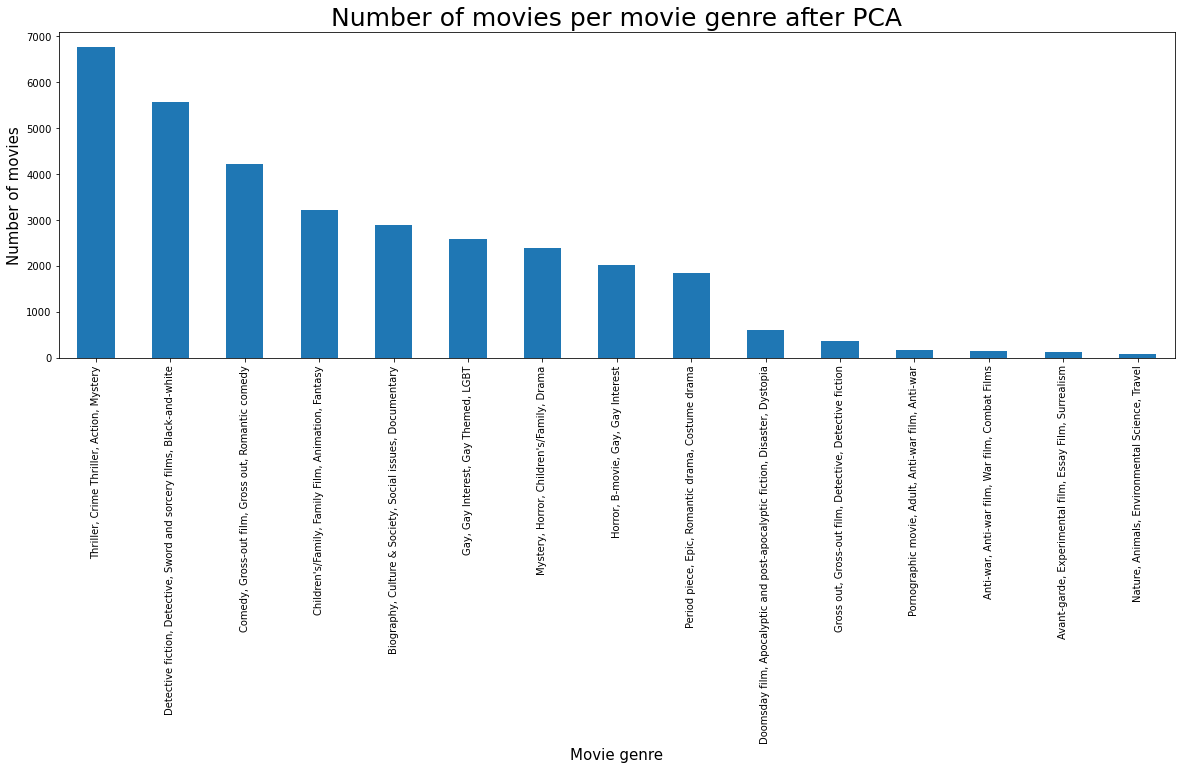

In [120]:
plt.figure(figsize=(20,6))
df_movies_USA_genre_PCA['m_genre_PCA'].value_counts().plot(kind='bar', figsize=(20,6))
plt.title('Number of movies per movie genre after PCA', fontsize = 25)
plt.xlabel('Movie genre', fontsize = 15)
plt.ylabel('Number of movies', fontsize = 15)
plt.show()

# 6. Data as a graph

In [121]:
temp_df = df_movies_USA.merge(df_USA_genres_one_hot[['m_genre_PCA']], left_on='wikipedia_m_ID', right_on='wikipedia_m_ID').drop(columns=['m_BO_revenue', 'm_runtime', 'm_languages', 'm_countries', 'm_genres', 'm_languages_freebase_ID', 'm_countries_freebase_ID', 'm_genres_freebase_ID'])

big_df = pd.merge(temp_df, df_chars, left_on=['wikipedia_m_ID', 'freebase_m_ID' , 'm_release_date'], right_on=['wikipedia_m_ID', 'freebase_m_ID' , 'm_release_date'])
big_df = big_df.drop(columns=['freebase_m_ID', 'actor_dob', 'actor_gender', 'actor_height', 'actor_ethnicity', 'actor_age', 'freebase_character_id', 'freebase_character_map', 'freebase_actor_id'])

big_df

,wikipedia_m_ID,m_name,m_release_date,m_genre_PCA,character_name,actor_name
0,975900,Ghosts of Mars,2001-08-24,"Thriller, Crime Thriller, Action, Mystery",Akooshay,Wanda De Jesus
1,975900,Ghosts of Mars,2001-08-24,"Thriller, Crime Thriller, Action, Mystery",Lieutenant Melanie Ballard,Natasha Henstridge
2,975900,Ghosts of Mars,2001-08-24,"Thriller, Crime Thriller, Action, Mystery",Desolation Williams,Ice Cube
3,975900,Ghosts of Mars,2001-08-24,"Thriller, Crime Thriller, Action, Mystery",Sgt Jericho Butler,Jason Statham
4,975900,Ghosts of Mars,2001-08-24,"Thriller, Crime Thriller, Action, Mystery",Bashira Kincaid,Clea DuVall
...,...,...,...,...,...,...
239219,24209227,"The Time, the Place and the Girl",1946-01-01,"Gay, Gay Interest, Gay Themed, LGBT",NaN,"Alan Hale, Sr."
239220,24209227,"The Time, the Place and the Girl",1946-01-01,"Gay, Gay Interest, Gay Themed, LGBT",NaN,Dennis Morgan
239221,24209227,"The Time, the Place and the Girl",1946-01-01,"Gay, Gay Interest, Gay Themed, LGBT",NaN,Janis Paige
239222,9971909,Another Nice Mess,1972-09-22,"Comedy, Gross-out film, Gross out, Romantic co...",NaN,Rich Little


In [122]:
action_actors = big_df
genre_dict = {}
for vec in action_actors.m_genre_PCA.drop_duplicates():
    genre_dict[vec] = action_actors[action_actors['m_genre_PCA'] == vec]

test_graph = genre_dict[", ".join(most_important_names[0])]

graph = pd.merge(test_graph, test_graph, on=['wikipedia_m_ID', 'm_name', 'm_release_date', 'm_genre_PCA'])
graph = graph[graph.actor_name_x < graph.actor_name_y]
graph.head()

,wikipedia_m_ID,m_name,m_release_date,m_genre_PCA,character_name_x,actor_name_x,character_name_y,actor_name_y
17,975900,Ghosts of Mars,2001-08-24,"Thriller, Crime Thriller, Action, Mystery",Lieutenant Melanie Ballard,Natasha Henstridge,Akooshay,Wanda De Jesus
22,975900,Ghosts of Mars,2001-08-24,"Thriller, Crime Thriller, Action, Mystery",Lieutenant Melanie Ballard,Natasha Henstridge,Commander Helena Braddock,Pam Grier
24,975900,Ghosts of Mars,2001-08-24,"Thriller, Crime Thriller, Action, Mystery",Lieutenant Melanie Ballard,Natasha Henstridge,Big Daddy Mars,Richard Cetrone
28,975900,Ghosts of Mars,2001-08-24,"Thriller, Crime Thriller, Action, Mystery",Lieutenant Melanie Ballard,Natasha Henstridge,Tres,Rodney A. Grant
29,975900,Ghosts of Mars,2001-08-24,"Thriller, Crime Thriller, Action, Mystery",Lieutenant Melanie Ballard,Natasha Henstridge,McSimms,Peter Jason


In [2]:
# graph with interactions between actors. not very interesting, even when plotting only the GCC
G = nx.from_pandas_edgelist(graph, 'actor_name_x', 'actor_name_y')

NameError: name 'nx' is not defined

For now, our PCA is too restrictive and does not allow this graph to be relevant. In milestone 3 we will improve it in a way so that it effectively shows co-acting relationships.

We could have plotted the whole dataset, but we wouldn't be able to see anything and would take a ridiculous amount of time to render.

Having PCA with different parameters, we could render the graphs below. We didn't include the code in the notebook yet because we are not sure if it is mathematically correct. However, the graphs are what we expect, that's why we find it relevant to include the graphs below.

In [124]:
#nx.draw(G, pos=nx.spring_layout(G), node_size=10, node_color=[(0., .8, 1, 0.24)] ,width=.1)

As the code takes a while to run, the image has been preprocessed and is imported as a png.

Graph with interactions between actors:

![graph](images/output.png)

As we can see, not all actors in this category are connected, let's see how the GCC looks like.

In [125]:
largest_cc = max(nx.connected_components(G), key=len)
GCC = G.subgraph(largest_cc)

In [126]:
#nx.draw(GCC, pos=nx.spring_layout(GCC), node_size=10, node_color=[(0., .8, 1, 0.24)] ,width=.1)

As the code takes a while to run, the image has been preprocessed and is imported as a png.

Giant connected components graph

![graph](images/output_gcc.png)

### 6.1 Node degree distribution

In graph theory, the degree of a node is the number of edges reaching a node. In our example, nodes are actors, and edges between nodes are movies in which both actors played. An important note is that not all actors are listed in our database, an average of 5 characters (hence actors) per movie are listed. Thus, the node degree of an actor is the number of films they played with another actor, according to our database.

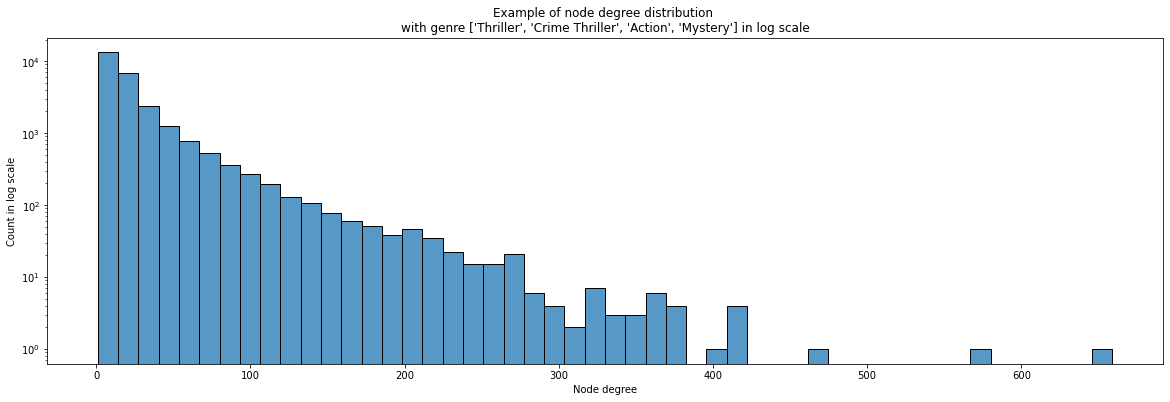

In [127]:
degree_sequence = sorted((d for n, d in G.degree()), reverse=True)
plt.figure(figsize=(20,6))
sns.histplot(degree_sequence, bins=50, log_scale = (False, True))
plt.title("Example of node degree distribution \nwith genre {} in log scale".format(most_important_names[0]))
plt.ylabel("Count in log scale")
plt.xlabel("Node degree")
plt.show()

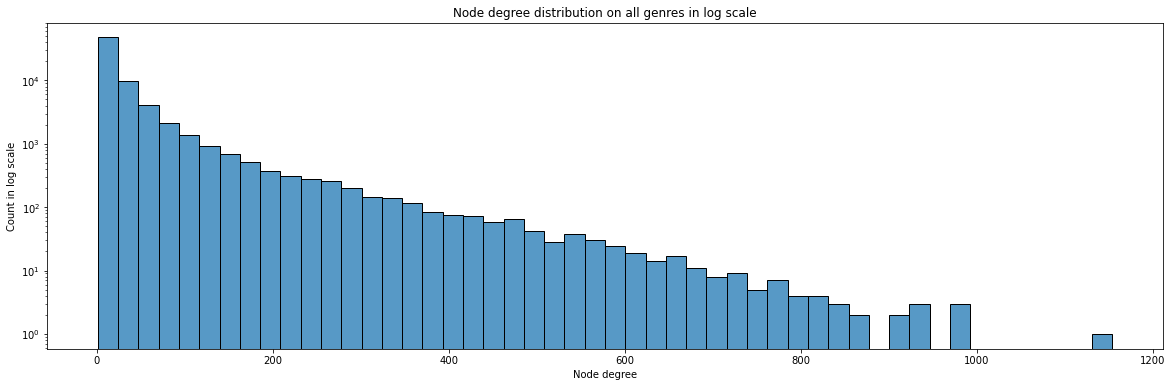

In [128]:
t_graph = pd.merge(big_df, big_df, on=['wikipedia_m_ID', 'm_name', 'm_release_date','m_genre_PCA'])
t_graph = t_graph[t_graph.actor_name_x < t_graph.actor_name_y]

G = nx.from_pandas_edgelist(t_graph, 'actor_name_x', 'actor_name_y')
degree_sequence = sorted((d for n, d in G.degree()), reverse=True)
plt.figure(figsize=(20,6))

sns.histplot(degree_sequence, bins=50, log_scale=(False,True))
plt.title("Node degree distribution on all genres in log scale")
plt.ylabel("Count in log scale")
plt.xlabel("Node degree")
plt.show()

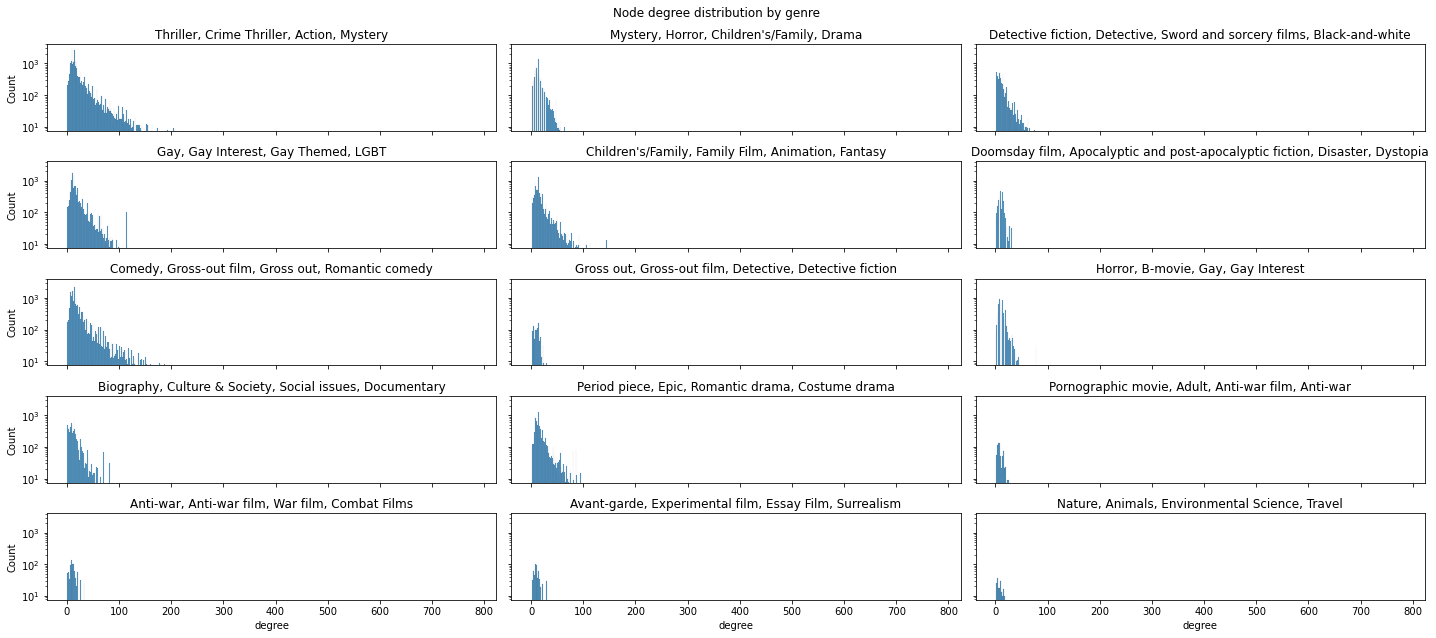

In [129]:
fig, axs = plt.subplots(5, 3, figsize=(20, 9), sharey='all', sharex='all')

i = 0
for k in genre_dict:
    ax= axs[int(i/3)][i%3]
    graph = pd.merge(genre_dict[k], genre_dict[k], on=['wikipedia_m_ID', 'm_name', 'm_release_date', 'm_genre_PCA'])
    graph = graph[graph.actor_name_x < graph.actor_name_y]
    g = nx.from_pandas_edgelist(graph, 'actor_name_x', 'actor_name_y')

    degree_sequence = sorted((d for n, d in g.degree()), reverse=True)
    sns.histplot(degree_sequence, log_scale=(False, True), ax=ax)
    ax.set_title(k)
    ax.set_xlabel("degree")
    i+=1
plt.suptitle("Node degree distribution by genre")
plt.tight_layout()
plt.show()

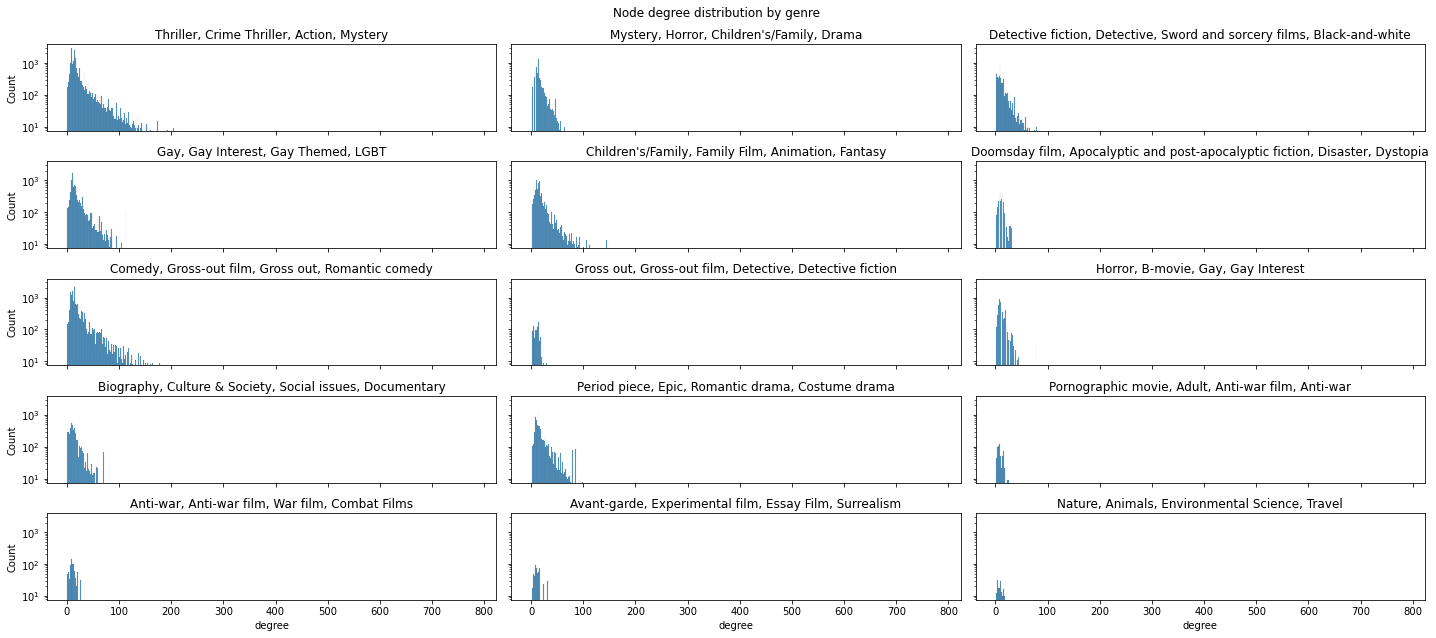

In [130]:
fig, axs = plt.subplots(5, 3, figsize=(20, 9), sharey='all', sharex='all')

i = 0
for k in genre_dict:
    ax= axs[int(i/3)][i%3]
    graph = pd.merge(genre_dict[k], genre_dict[k], on=['wikipedia_m_ID', 'm_name', 'm_release_date', 'm_genre_PCA'])
    graph = graph[graph.actor_name_x < graph.actor_name_y]
    g = nx.from_pandas_edgelist(graph, 'actor_name_x', 'actor_name_y')
    largest_cc = max(nx.connected_components(G), key=len)
    gcc = g.subgraph(largest_cc)

    degree_sequence = sorted((d for n, d in gcc.degree()), reverse=True)
    sns.histplot(degree_sequence, log_scale=(False, True), ax=ax)
    ax.set_title(k)
    ax.set_xlabel("degree")
    i+=1
plt.suptitle("Node degree distribution by genre")
plt.tight_layout()
plt.show()

The distribution is really similar in both figures due to the fact that the GCC usually captures 95% of more of the data.

### 6.2 Actors intersection between genres

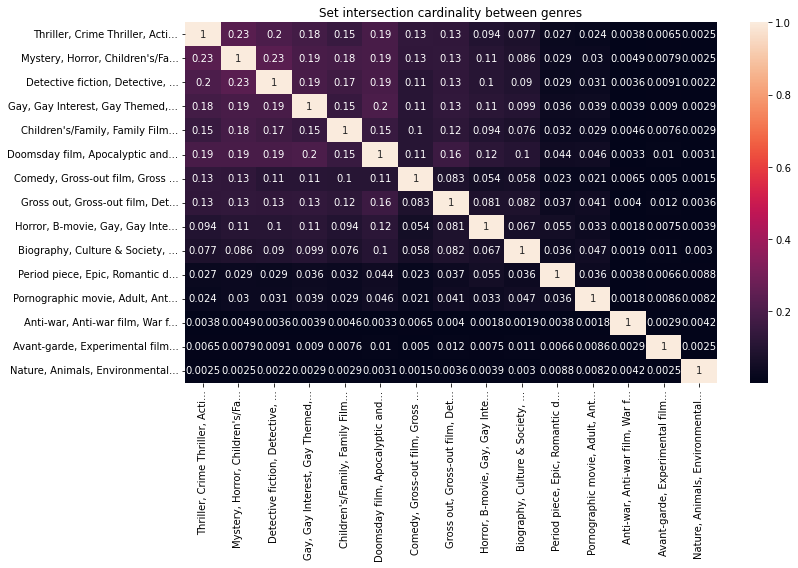

In [131]:
plt.figure(figsize=(12, 8))
intersection_log = np.empty((15, 15))
intersection = np.empty((15, 15))
actors = []
heatmap_labels = []

for k in genre_dict:
    actor_set = set(genre_dict[k]['actor_name'])
    actors.append([k, len(actor_set), actor_set])
    heatmap_labels.append(k[:30]+"...")

actors.sort(key=lambda x: x[1], reverse=True)

for i, genre1 in enumerate(actors):
    for j, genre2 in enumerate(actors):
        intersection[i][j] = len(genre1[2].intersection(genre2[2]))/len(genre1[2].union(genre2[2]))


sns.heatmap(intersection,  annot=True, yticklabels=heatmap_labels, xticklabels=heatmap_labels)

plt.title('Set intersection cardinality between genres')
plt.tight_layout()
plt.show()

As shown in the graph above, it can be seen that there are two stages depicting the intersections between different genres. Roughly, the four biggest genres in terms of actors cardinality size have a bigger overlapping density.

### 6.3 Genre evolution in career length

In [132]:
# find distribution for 1st film, second film, ... per actor
test = big_df.sort_values(['actor_name', 'm_release_date']).reset_index()[['m_genre_PCA', 'actor_name']]
test['number'] = 0
test.dropna(subset='actor_name', axis=0, inplace=True)
prev_actor = ""
i = 0
test = test[test.actor_name != 'Mel Blanc']
for idx, row in test.iterrows():
    if row.actor_name != prev_actor:
        prev_actor = row.actor_name
        i = 0
    i+=1
    test.at[idx, 'number'] = i

In [133]:
stacked_df = pd.DataFrame()
for group in test.groupby('m_genre_PCA'):
    tmp = group[1].groupby('number').count()['actor_name']
    tmp = tmp.reindex(list(range(1,tmp.index.max()+1)), fill_value=0)
    stacked_df[group[0]] = tmp

stacked_df = stacked_df.fillna(0)

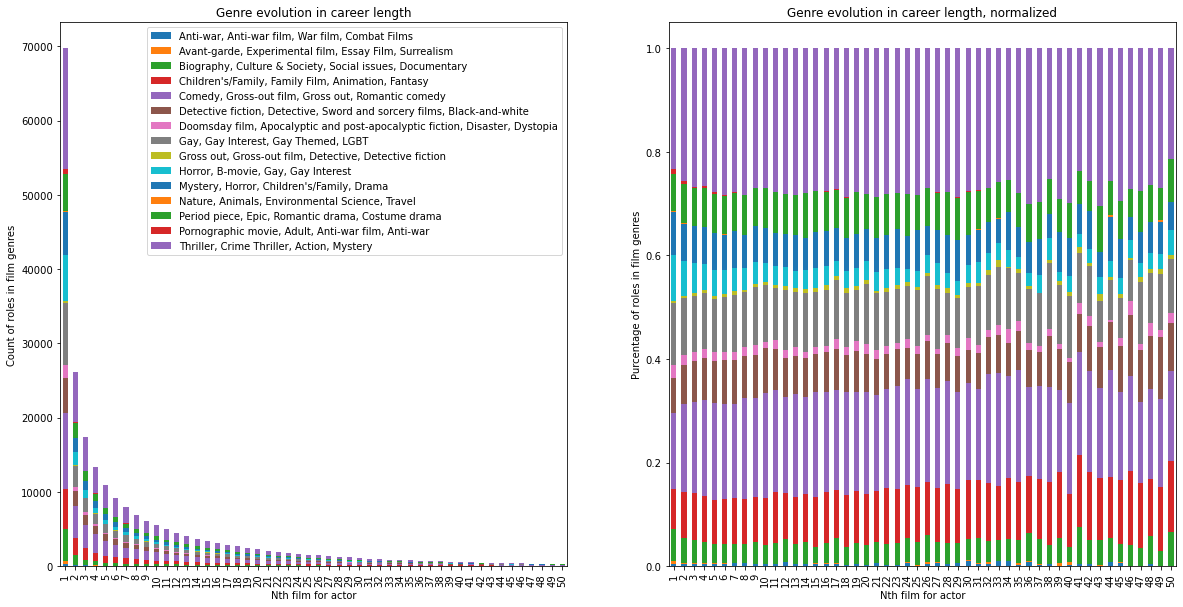

In [134]:
fig, axs = plt.subplots(1, 2, figsize=(20,10))
stacked_df.head(50).plot(kind='bar', stacked=True, ax=axs[0])
axs[0].set_title('Genre evolution in career length')
axs[0].set_xlabel('Nth film for actor')
axs[0].set_ylabel('Count of roles in film genres')
norm_stacked = stacked_df.copy()
norm_stacked = norm_stacked.apply(lambda row: row/row.sum(), axis=1)

norm_stacked.head(50).plot(kind='bar', stacked=True, ax=axs[1], legend=False)
axs[1].set_title('Genre evolution in career length, normalized')
axs[1].set_xlabel('Nth film for actor')
axs[1].set_ylabel('Purcentage of roles in film genres')

plt.show()

The graph depicts the career evolution of actors in terms of gender. The x-axis can be considered as "experience" of an actor. As shown in the graph, it can be seen that there is roughly no growing number of movies per genre. It means that there is no genre that requires a particular experience of actors.

#  7. The numbers data: Domestic Per Year Acting Box Office Star Records
<a class="anchor" id="numbers"></a>

### What is this extra dataset, why did we need one and what does it contain ?
This website extracts, analyses and offers interesting data about movies. They call themseleves "the premier provider of movie industry data and research services." As they permit hand-copying data from their website, [the domestic per year acting box office star records from year 1980 to 2022](https://www.the-numbers.com/box-office-star-records/domestic/yearly-acting/) have been extracted and zipped. This freshly scraped data contains the actor's name, the "popularity index" and the average billing rate.

The popularity index represent points assigned to each of the acotr·ress appearing in the top 100 (based on US box office) movies in the current year and two preceding years. For appearing in the number one movie in a year a acotr gets 100 points, the number two movie 99 points and so on.

The box office is a debatble metric as it does not take into acount the wage of the cast, the cost of filiming nor the revenues of the streaming platforms (one time download or subscription to the plateform). Thankfully the latter has little or no influence for BO computed before 2000.

Nevertheless, we will still use this metric as it's so common standard in the movie industry.

#### But why did we need this dataset ?

In order to help answer our question, a popularity index for the actors has to be used. This will allow us to analyse the co-acting. For example if a not popular actor has a peak in it's poularity index, we retrieve all the films in which they've played during that time. They may be or not a popular acotr that was part of the cast and thanks to the latter the career of the first has boomed. This is one of many possible ways to analysis the co-acting

### 7.1 Load the data
<a class="anchor" id="load_the_numbers"></a>

In [135]:
#CONSTANTS
YEAR_OFFSET=2 # if 3: last triplet 2019, 2020, 2021;; if 2: last triplet 2020, 2021, 2022
START_INDEX=28 # 20 correspond to the triplet 2000, 2001, 2002
START_YEAR=1980+START_INDEX

In [136]:
#read the tsv files having the actor's popularity
tab_years=np.arange(1980,2022+1)
actors_rating=[]
for i, year in enumerate (tab_years):
    path_numbers = os.path.join(THE_NUMBERS_PATH, 'actors_{}_the_numbers.tsv'.format(year))
    actors_rating.append(pd.read_csv(path_numbers,
                              sep='\t',
                              escapechar=',',
                              names=['actor_name','popularity', 'movies', 'avg_billing']))

### 7.2 Creation of a pipeline

#### Check for duplicated actor name for each year

In [137]:
#check for duplicated actor name for each year
total_duplicated=0
for i in range (len(tab_years)):
    total_duplicated+=actors_rating[i].duplicated(subset='actor_name').sum()
print('There are {} actors that appear twice in the same year.'.format(total_duplicated))

There are 0 actors that appear twice in the same year.


#### Formatting the dataset in a useful way

In [138]:
number_actors_per_year=[]
df_ratings_all_years=actors_rating[0].set_index('actor_name')[['popularity']]
df_ratings_all_years.set_axis([*df_ratings_all_years.columns[:-1], '{}'.format(1980)], axis=1, inplace=True)
for i in range (len(tab_years)-1):
    number_actors_per_year.append((len(actors_rating[i+1])))
    df_ratings_all_years=pd.concat([df_ratings_all_years, actors_rating[i+1].set_index('actor_name')[['popularity']]],  axis=1)
    df_ratings_all_years.set_axis([*df_ratings_all_years.columns[:-1], '{}'.format(i+1+1980)], axis=1, inplace=True)
df_ratings_all_yearsT=df_ratings_all_years.T

ACTORS=list(df_ratings_all_yearsT)#all the actors present in the numbers dataset

print('There is a total of {} actors in the Number dataset.'.format(len(ACTORS)))

There is a total of 2702 actors in the Number dataset.


#### Mean of the score per actor

In [139]:
df_ratings_all_years['mean_score'] = df_ratings_all_years.mean(axis=1)
print("Actors with the highest mean popularity score computed on the 42 years of the dataset.")
df_ratings_all_years.sort_values(by='mean_score', ascending=False).head()

Actors with the highest mean popularity score computed on the 42 years of the dataset.


,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,mean_score
actor_name,,,,,,,,,,,,,,,,,,,,,
Jennifer Lawrence,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,561.0,518.0,489.0,298.0,195.0,97.0,97.0,57.0,NaN,283.636364
Chris Hemsworth,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,330.0,198.0,216.0,309.0,342.0,394.0,301.0,165.0,95.0,265.666667
Chris Pratt,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,98.0,197.0,337.0,335.0,432.0,392.0,296.0,100.0,98.0,253.888889
Kevin Hart,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,248.0,304.0,437.0,368.0,307.0,324.0,227.0,165.0,NaN,252.900000
John Candy,NaN,NaN,NaN,NaN,NaN,205.0,253.0,405.0,276.0,331.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,241.666667


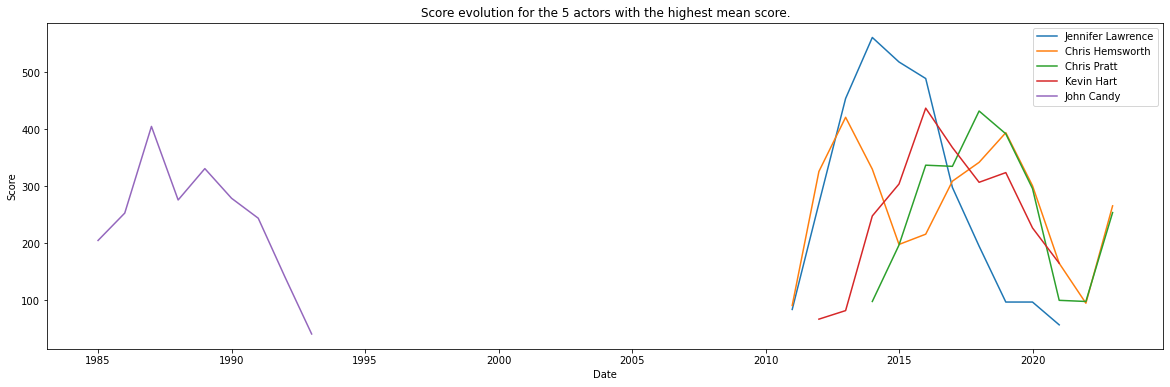

In [140]:
df_ratings_all_years.sort_values(by='mean_score', ascending=False).head().rename_axis(None).T.plot(figsize=(20,6))
plt.title("Score evolution for the 5 actors with the highest mean score.")
plt.xlabel('Date')
plt.ylabel('Score')
plt.show()

#### Looking at the actor with most scores

In [141]:
df_ratings_all_years['is_na']=df_ratings_all_years.apply(lambda row: row.isna().sum().sum(), axis=1)
print("Actors that have the least \"empty years\" throughout the 42 years of the dataset.")
df_ratings_all_years.sort_values(by='is_na', ascending=True).head(3)

Actors that have the least "empty years" throughout the 42 years of the dataset.


,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,...,2015,2016,2017,2018,2019,2020,2021,2022,mean_score,is_na
actor_name,,,,,,,,,,,,,,,,,,,,,
Harrison Ford,158.0,258.0,279.0,279.0,277.0,290.0,234.0,136.0,179.0,234.0,...,130.0,22.0,67.0,67.0,67.0,95.0,95.0,95.0,158.837209,0
Robert De Niro,169.0,115.0,115.0,39.0,28.0,28.0,80.0,92.0,165.0,130.0,...,185.0,129.0,129.0,20.0,NaN,86.0,86.0,141.0,147.238095,1
Meryl Streep,162.0,229.0,141.0,223.0,184.0,206.0,188.0,160.0,64.0,35.0,...,141.0,125.0,80.0,227.0,220.0,158.0,NaN,NaN,127.800000,3


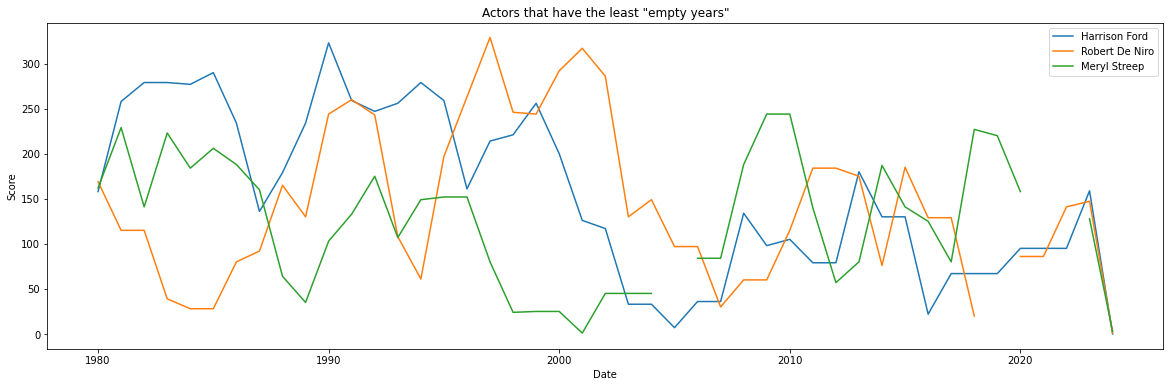

In [142]:
df_ratings_all_years.sort_values(by='is_na', ascending=True).head(3).rename_axis(None).T.plot(figsize=(20,6))
plt.title("Actors that have the least \"empty years\"")
plt.xlabel('Date')
plt.ylabel('Score')
plt.show()

#### Actors that have played in a given year

In [143]:
def find_yearly_actors(row):
    """
    finds all the actors that have a popularity score in a given year.
    :param row: each row of the dataframe sent by .apply()
    :return: dictionnary with each actor and the score of a given year
    """
    year_dict={}
    for i, actor in enumerate (ACTORS):
        if row[actor] > 0:
            year_dict.update({'{}'.format(actor):row[actor]})
    return year_dict

df_ratings_all_yearsT['have_score']=df_ratings_all_yearsT.apply(lambda row: find_yearly_actors(row), axis=1)
list_have_score=df_ratings_all_yearsT['have_score'].tolist()
df_ratings_all_yearsT.head()

actor_name,Jane Fonda,Clint Eastwood,John Belushi,Burt Reynolds,Goldie Hawn,Chevy Chase,Alan Alda,Laurence Olivier,Chuck Norris,John Travolta,...,Jenna Ortega,Billy Eichner,Luke Macfarlane,Maria Bakalova,Myha’la Herrold,Chase Sui Wonders,Rachel Sennott,Pete Davidson,Lesley Manville,have_score
1980,440.0,360.0,269.0,262.0,258.0,248.0,227.0,206.0,201.0,188.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{'Jane Fonda': 440.0, 'Clint Eastwood': 360.0,..."
1981,364.0,263.0,295.0,84.0,170.0,289.0,62.0,67.0,131.0,132.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{'Jane Fonda': 364.0, 'Clint Eastwood': 263.0,..."
1982,198.0,260.0,217.0,NaN,251.0,289.0,NaN,NaN,105.0,132.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{'Jane Fonda': 198.0, 'Clint Eastwood': 260.0,..."
1983,99.0,180.0,125.0,NaN,81.0,261.0,NaN,NaN,87.0,208.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{'Jane Fonda': 99.0, 'Clint Eastwood': 180.0, ..."
1984,NaN,347.0,NaN,NaN,147.0,132.0,NaN,NaN,143.0,164.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{'Clint Eastwood': 347.0, 'Goldie Hawn': 147.0..."


In [144]:
list_have_score_triplet=[]
temp_dict={}

for i in range (len(list_have_score)-YEAR_OFFSET):
    """
    find actors that have a score in three consecutive years n, n+1, n+2. 
    """
    intersection=list(set(list_have_score[i].keys()) & set(list_have_score[i+1].keys()) & set(list_have_score[i+2].keys()))
    have_score_3years={actor : [list_have_score[i][intersection[j]], list_have_score[i+1][intersection[j]], list_have_score[i+2][intersection[j]]] for j, actor in enumerate(intersection)}
    list_have_score_triplet.append(have_score_3years)
    
for i in range (YEAR_OFFSET):
    list_have_score_triplet.append(temp_dict)
    
df_ratings_all_yearsT['have_score_triplet']=list_have_score_triplet

#### Actors that have a peak in their score given a threshold

In [145]:
def find_peak(x, threshold=60):
    """
    find a peak of popularity in the carrier of an actor. A peak is defined if from one year to another the popularity has increased by a given thershold.
    :param x: each line of the 'have_score_triplet' column sent by .apply()
    :return: dictionnary with the actors that have a peak in popularity for a given year triplet
    """
    temp_dict={}
    for key, value in x.items():
        if (value[0]+threshold<value[1] or value[1]+threshold<value[2]):
            value.append(1)
        else:
            value.append(0)
        temp_dict.update({key:value})
    return temp_dict

df_ratings_all_yearsT['have_score_triplet']=df_ratings_all_yearsT['have_score_triplet'].apply(lambda x: find_peak(x))
df_ratings_all_yearsT.head()

actor_name,Jane Fonda,Clint Eastwood,John Belushi,Burt Reynolds,Goldie Hawn,Chevy Chase,Alan Alda,Laurence Olivier,Chuck Norris,John Travolta,...,Billy Eichner,Luke Macfarlane,Maria Bakalova,Myha’la Herrold,Chase Sui Wonders,Rachel Sennott,Pete Davidson,Lesley Manville,have_score,have_score_triplet
1980,440.0,360.0,269.0,262.0,258.0,248.0,227.0,206.0,201.0,188.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{'Jane Fonda': 440.0, 'Clint Eastwood': 360.0,...","{'Angela Lansbury': [108.0, 39.0, 39.0, 0], 'J..."
1981,364.0,263.0,295.0,84.0,170.0,289.0,62.0,67.0,131.0,132.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{'Jane Fonda': 364.0, 'Clint Eastwood': 263.0,...","{'Karen Allen': [100.0, 100.0, 100.0, 0], 'Rob..."
1982,198.0,260.0,217.0,NaN,251.0,289.0,NaN,NaN,105.0,132.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{'Jane Fonda': 198.0, 'Clint Eastwood': 260.0,...","{'Steve Guttenberg': [47.0, 47.0, 142.0, 1], '..."
1983,99.0,180.0,125.0,NaN,81.0,261.0,NaN,NaN,87.0,208.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{'Jane Fonda': 99.0, 'Clint Eastwood': 180.0, ...","{'David Carradine': [47.0, 47.0, 47.0, 0], 'Al..."
1984,NaN,347.0,NaN,NaN,147.0,132.0,NaN,NaN,143.0,164.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{'Clint Eastwood': 347.0, 'Goldie Hawn': 147.0...","{'George Gaynes': [95.0, 184.0, 184.0, 1], 'Sh..."


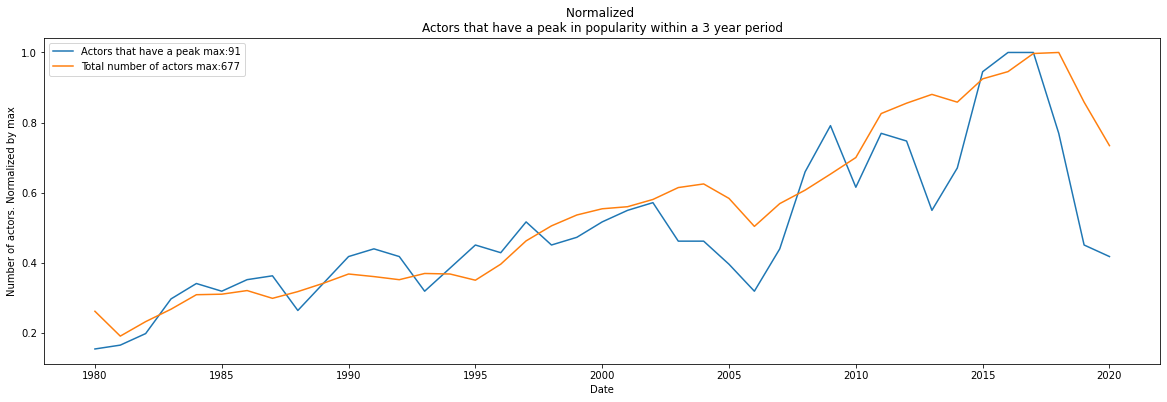

In [146]:
def is_peak (x):
    """
    retrieve all the actors that have a peak within the three consecutive years.
    :param x:  each line of the 'have_score_triplet' column sent by .apply()
    :return: disctionnary with only the actors that have a peak
    """
    my_dict={}
    for key, value in x.items():
        if value[3]==1:
            my_dict.update({key:value})
    return my_dict

numbers_actors_have_peak=[]
df_ratings_all_yearsT['is_peak']=df_ratings_all_yearsT['have_score_triplet'].apply(lambda x: is_peak(x))
for i in range (df_ratings_all_yearsT.shape[0]-YEAR_OFFSET):
    numbers_actors_have_peak.append(len(df_ratings_all_yearsT.iloc[i]['is_peak']))

plt.figure(figsize = (20, 6))
plt.plot(tab_years[:-YEAR_OFFSET], numbers_actors_have_peak/np.max(numbers_actors_have_peak))
plt.plot(tab_years[:-YEAR_OFFSET], number_actors_per_year[:-1]/np.max(number_actors_per_year[:-1]))
plt.legend(['Actors that have a peak max:{}'.format(np.max(numbers_actors_have_peak)), 'Total number of actors max:{}'.format(np.max(number_actors_per_year[:-1]))])
plt.title("Normalized \nActors that have a peak in popularity within a 3 year period")
plt.xlabel("Date")
plt.ylabel("Number of actors. Normalized by max")
plt.show()

The plot above shows that an increasing number of actors have a peak in the score. This can be explained by the fact that more films are made meaning more actors have a potential to have a peak in their score. This is proven by plotting both curves that follow each other.

### 7.3 Comparing the numbers dataset with the CMU dataset
<a class="anchor" id="numbers_dataset"></a>

Comparing both datasets is made with one year triplet. This gives a general idea of what is possible and how the numbers dataset can be used.

#### Looking at only one year triplet

In [147]:
#this part is done with only one triplet of year to see how this analysis is implemented.
df_m_a_release=df_m_a[['m_name', 'm_release_date', 'character_name', 'actor_name']]

df_filtered_year=df_m_a_release.loc[(df_m_a_release['m_release_date'].dt.year==START_YEAR)|
                                    (df_m_a_release['m_release_date'].dt.year==START_YEAR+1)|
                                    (df_m_a_release['m_release_date'].dt.year==START_YEAR+2)]

actors_of_triplet=list(df_ratings_all_yearsT.iloc[START_INDEX]['is_peak'].keys()) # years 2008, 2009, 2010

#find the films in which the selected actors have played in.
films_with_actor_triplet=df_filtered_year.loc[df_filtered_year['actor_name'].isin(actors_of_triplet)]
print("There are {} movies in which actors that have a peak in popularity for years {}, {}, {} have played in.".format(len(films_with_actor_triplet['m_name'].unique()), START_YEAR, START_YEAR+1, START_YEAR+2))
films_with_actor_triplet.head()

There are 228 movies in which actors that have a peak in popularity for years 2008, 2009, 2010 have played in.


,m_name,m_release_date,character_name,actor_name
742,The Forbidden Kingdom,2008-04-04,The Monkey King / The Silent Monk,Jet Li
1419,Just Wright,2010-05-14,Leslie Wright,Queen Latifah
1610,Get Smart's Bruce & Lloyd Out of Control,2008-01-01,Agent 99,Anne Hathaway
2157,A Single Man,2009-09-11,George,Colin Firth
2375,The Last Song,2010-03-31,Veronica 'Ronnie' Miller,Miley Cyrus


In [148]:
print("Some special cases have been found. This is one example: \nIn Iron man 2 Robert Downey Jr. and Scarlette Johansson both appear twice.")
print("This will need to be taken into account when hadling this data.")
films_with_actor_triplet.loc[films_with_actor_triplet['m_name']=='Iron Man 2']

Some special cases have been found. This is one example: 
In Iron man 2 Robert Downey Jr. and Scarlette Johansson both appear twice.
This will need to be taken into account when hadling this data.


,m_name,m_release_date,character_name,actor_name
6909,Iron Man 2,2010-04-26,Tony Stark,Robert Downey Jr.
6910,Iron Man 2,2010-04-26,Iron Man,Robert Downey Jr.
6912,Iron Man 2,2010-04-26,Black Widow,Scarlett Johansson
6913,Iron Man 2,2010-04-26,Pepper Potts,Gwyneth Paltrow
6933,Iron Man 2,2010-04-26,Natasha Romanoff,Scarlett Johansson


#### Find all the films played by an actor

In [149]:
m_actors_played_in_triplet={}#dictionary where the keys are the actors and the values are the film in which the've played during the triplet period
unique_films_in_triplet=[]
for i, actor in enumerate (films_with_actor_triplet['actor_name']):
    film_in_triplet=films_with_actor_triplet.loc[films_with_actor_triplet['actor_name']==actor]['m_name'].tolist()
    m_actors_played_in_triplet.update({actor:film_in_triplet})

#### Intermediate conclusion

This part was the preliminary study of the numbers dataset. A general pipeline was created enabling further study of this dataset. Comparing the number dataset with the CMU dataset was made only for one year triplet in order to understand if this dataset makes sence for replying our question. For the final milestone, a complete study using all the triplets will be made.